This code, requested by Paul, was intended to accomplish two (three) tasks. We need to produce all-encompassing, humongous database files containing the following.

* A `positions` database containing the position of all objects, players, etc. across all participants. The data should be modded to include:
    * The position of the user in world space
* A `eeg` database containing all eeg data across all participants. The data should be modded such that:
    * Any rows with gaps in the data should be filtered out.
* A `eye` database containing all eye data across all participants. The data should be modded to include:
    * Local data timestamp.
    * The distance between the user and the gaze target.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import datetime
from scipy.stats import kendalltau, pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving string->int mappings during correlation analysis

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# constants
_INPUT_DATA_DIR = '../data/'
_OUTPUT_DATA_DIR = f'./geosim_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/'
_PARTICIPANTS = ['P0','P1','P2','P3','P4','P5','P6']
_ROAD_RANGE = [2.25, 7.75]

# Helper function to create a directory if not exists
def try_make_dir(a_dir:str):
    try: os.makedirs(a_dir)
    except OSError as e:
        if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

# Helper function for detecting files, from '../helpers.py'
def get_immediate_files(a_dir:str):
    return [name for name in os.listdir(a_dir)
            if os.path.isfile(os.path.join(a_dir, name))]

# Helper function to parse raycast hit names. Does so by process raycast_hit_name 
#   into different segments, based on delimiters.
def raycast_processing(raw_value):
    if len(raw_value) == 0: return '','','',''
    divided = raw_value.split("-")
    values = divided[0].split('.')
    values.append(divided[1])
    return values

In [3]:
try_make_dir(_OUTPUT_DATA_DIR)

# Positions & On-Roads

The idea is that we want to label all our data by whether the user is on the road or not. This would indicate that someone is perhaps crossing or not. We also need to process the positions to include the necessary data.

In [4]:
# Initialize multiple lists to store all the positions, player positions, and on_road data.
# We will concatenate these later into huge dataframes
trials_dfs = []
positions_dfs = []
players_dfs = []
on_roads_dfs = []

# Iterate through participants
for p in _PARTICIPANTS:
    # Get the neceesary files, check if file exists or not
    pdir = os.path.join(_INPUT_DATA_DIR, p)
    pfiles = get_immediate_files(pdir)
    if "positions_mod.csv" not in pfiles:
        print(f"ERROR: 'positions_mod.csv' not available in {p}'s data'")
        continue
        
    # Read the trial data for this participant.
    # We simply need this to restrict the eye gazes between a time range.
    tdf = pd.read_csv(os.path.join(pdir,'trials.csv'))
    tdf = tdf[tdf['trial_number']>=1]
    start_frame = tdf['start_frame'].iloc[0]
    end_frame = tdf['end_frame'].iloc[-1]
    
    # Read the csv file, filter to only the trial data
    pos_df = pd.read_csv(os.path.join(pdir,'positions_mod.csv'))
    pos_df = pos_df[pos_df['frame'].between(start_frame, end_frame)]
    
    # Create a new timestamp col for the local timestamp
    pos_df['local_timestamp'] = pos_df['unix_ms'].apply(lambda t: datetime.datetime.fromtimestamp(t/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
    
    # Add the participant ID to each row
    pos_df['participant'] = p
    
    # Add the trial number based on frame number and trials
    trial_intervals = pd.IntervalIndex.from_arrays(tdf['start_frame'], tdf['end_frame'], closed='left')
    pidx = trial_intervals.get_indexer(pos_df['frame'])
    pos_df['trial_number'] = tdf['trial_number'].iloc[pidx].where(pidx != -1).values
    
    # Create a player-specific dataframe
    player_df = pos_df[pos_df['obj_name'] == 'CenterEyeAnchor']
    player_df = player_df.reset_index(drop=True)
    
    # Mod the player-specific dataframe to include speed and displacement
    player_df['time_diff'] = player_df['unix_ms'].diff() / 1000 # unix ms to sec
    player_df['displacement'] = np.sqrt((player_df['pos_x'].diff()**2) + (player_df['pos_z'].diff()**2))
    player_df['speed'] = player_df['displacement'] / player_df['time_diff']
    # Make sure we don't have NaN values in the first sample row
    player_df.iloc[0, player_df.columns.get_loc('time_diff')] = 0
    player_df.iloc[0, player_df.columns.get_loc('displacement')] = 0
    player_df.iloc[0, player_df.columns.get_loc('speed')] = 0
    
    # Calculate crossing moments
    moving_df = player_df[player_df['pos_z'].between(_ROAD_RANGE[0], _ROAD_RANGE[1])]
    moving_df['next_frame'] = moving_df['frame'].shift(-1)
    moving_df['frame_diff'] = moving_df['next_frame'] - moving_df['frame']
    moving_df['group'] = (moving_df['next_frame'] != moving_df['frame'] + 1).cumsum()
    moving_df = moving_df[moving_df['frame_diff']==1]
    
    # Crossings defined by combinin g disparate movement segments
    crossing_df = moving_df.groupby('group').agg(
        start_unix_ms=('unix_ms', 'first'),
        start_frame=('frame','first'),
        start_rel_timestamp=('rel_timestamp','first'),
        start_local_timestamp=('local_timestamp','first'),
        end_unix_ms=('unix_ms', 'last'),
        end_frame=('frame','last'),
        end_rel_timestamp=('rel_timestamp','last'),
        end_local_timestamp=('local_timestamp','last'),
        group=('group','first')
    )
    crossing_df = crossing_df.reset_index(drop=True)
    crossing_df = crossing_df.drop(columns=['group'])
    crossing_df['participant'] = p
    cidx = trial_intervals.get_indexer(crossing_df['start_frame'])
    crossing_df['trial_number'] = tdf['trial_number'].iloc[cidx].where(cidx != -1).values
    
    # Label each position based on whether the user is crossing or not.
    crossing_intervals = pd.IntervalIndex.from_arrays(crossing_df['start_frame'], crossing_df['end_frame'], closed='both')
    player_df['on_road'] = player_df['frame'].apply(lambda frame: any(frame in interval for interval in crossing_intervals))
    
    # Add everything to our list of dataframes
    trials_dfs.append(tdf)
    positions_dfs.append(pos_df)
    players_dfs.append(player_df)
    on_roads_dfs.append(crossing_df)

In [5]:
# Let's concatenate everything together into their massive dataframes
positions_df = pd.concat(positions_dfs, ignore_index=True)
players_df = pd.concat(players_dfs, ignore_index=True)
on_roads_df = pd.concat(on_roads_dfs, ignore_index=True)

# Let's save our dataframes
positions_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'positions_all.csv'))
players_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'player_positions_all.csv'))
on_roads_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'on_roads_all.csv'))

display(positions_df)
display(players_df)
display(on_roads_df)

unix_ms  rel_timestamp  frame                 obj_name    guid  \
0        1742842039794       27.37964   1271                HighMale2   29686   
1        1742842039794       27.37964   1271          CenterEyeAnchor   27386   
2        1742842039794       27.37964   1271               LowFemale2   33854   
3        1742842039794       27.37964   1271              HighFemale2   33816   
4        1742842039794       27.37964   1271                 LowMale2   28708   
...                ...            ...    ...                      ...     ...   
1464397  1743103505858      257.39490  13182  Head-Remy-Car1-Detailed -288314   
1464398  1743103505858      257.39490  13182       Remy-Car2-Detailed -282146   
1464399  1743103505858      257.39490  13182  Remy-SportCar5-Detailed -284356   
1464400  1743103505858      257.39490  13182       Remy-Car1-Detailed -288120   
1464401  1743103505858      257.39490  13182       SportCar5-Detailed   27150   

             pos_x     pos_y      pos_z  forward_x  forward_y     forward_z  \
0        55.194620  0.025000  -1.829232   0.994431   0.000000 -1.053876e-01   
1         0.023046  1.510251   7.537932   0.018721   0.083370  9.963428e-01   
2        49.259030  0.025000  11.288620   0.999992   0.000000  4.029572e-03   
3       -48.015770  0.025000  -1.138340  -0.998273   0.000000 -5.873787e-02   
4       -57.869670  0.025000  13.540730  -1.000000   0.000000  5.820990e-04   
...            ...       ...        ...        ...        ...           ...   
1464397  56.269520  1.079971   4.243897   0.928800  -0.370325 -1.381822e-02   
1464398  23.699140  0.271200   5.766800  -1.000000   0.000000 -1.192093e-07   
1464399 -38.634860  0.220800   4.209200   1.000000   0.000000 -1.192093e-07   
1464400  56.391880  0.176000   4.233200   1.000000   0.000000 -1.192093e-07   
1464401 -38.783660  0.000000   3.750000   1.000000   0.000000 -1.192093e-07   

                    local_timestamp participant  trial_number  
0        2025-03-24 14:47:19.794000          P0             1  
1        2025-03-24 14:47:19.794000          P0             1  
2        2025-03-24 14:47:19.794000          P0             1  
3        2025-03-24 14:47:19.794000          P0             1  
4        2025-03-24 14:47:19.794000          P0             1  
...                             ...         ...           ...  
1464397  2025-03-27 15:25:05.858000          P6             8  
1464398  2025-03-27 15:25:05.858000          P6             8  
1464399  2025-03-27 15:25:05.858000          P6             8  
1464400  2025-03-27 15:25:05.858000          P6             8  
1464401  2025-03-27 15:25:05.858000          P6             8  

[1464402 rows x 14 columns]

unix_ms  rel_timestamp  frame         obj_name   guid     pos_x  \
0      1742842039794       27.37964   1271  CenterEyeAnchor  27386  0.023046   
1      1742842039819       27.40971   1272  CenterEyeAnchor  27386  0.021145   
2      1742842039847       27.43442   1273  CenterEyeAnchor  27386  0.018981   
3      1742842039874       27.46282   1274  CenterEyeAnchor  27386  0.016246   
4      1742842039902       27.48971   1275  CenterEyeAnchor  27386  0.013274   
...              ...            ...    ...              ...    ...       ...   
85462  1743103505745      257.28380  13178  CenterEyeAnchor  27386 -0.230588   
85463  1743103505773      257.31080  13179  CenterEyeAnchor  27386 -0.232035   
85464  1743103505801      257.33880  13180  CenterEyeAnchor  27386 -0.230375   
85465  1743103505829      257.36710  13181  CenterEyeAnchor  27386 -0.230330   
85466  1743103505858      257.39490  13182  CenterEyeAnchor  27386 -0.229302   

          pos_y     pos_z  forward_x  forward_y  forward_z  \
0      1.510251  7.537932   0.018721   0.083370   0.996343   
1      1.509382  7.568877   0.010008   0.075531   0.997093   
2      1.507867  7.599664   0.000239   0.062762   0.998028   
3      1.505601  7.630500  -0.007303   0.056803   0.998359   
4      1.502432  7.661299  -0.012210   0.057715   0.998258   
...         ...       ...        ...        ...        ...   
85462  1.543497  7.376041   0.368187   0.004125   0.929743   
85463  1.554049  7.418886   0.398355   0.011807   0.917155   
85464  1.565750  7.459814   0.417578   0.033772   0.908013   
85465  1.571815  7.499619   0.440730   0.026427   0.897251   
85466  1.577060  7.539467   0.460544   0.012118   0.887554   

                  local_timestamp participant  trial_number  time_diff  \
0      2025-03-24 14:47:19.794000          P0             1      0.000   
1      2025-03-24 14:47:19.819000          P0             1      0.025   
2      2025-03-24 14:47:19.847000          P0             1      0.028   
3      2025-03-24 14:47:19.874000          P0             1      0.027   
4      2025-03-24 14:47:19.902000          P0             1      0.028   
...                           ...         ...           ...        ...   
85462  2025-03-27 15:25:05.745000          P6             8      0.028   
85463  2025-03-27 15:25:05.773000          P6             8      0.028   
85464  2025-03-27 15:25:05.801000          P6             8      0.028   
85465  2025-03-27 15:25:05.829000          P6             8      0.028   
85466  2025-03-27 15:25:05.858000          P6             8      0.029   

       displacement     speed  on_road  
0          0.000000  0.000000     True  
1          0.031003  1.240133     True  
2          0.030863  1.102249     True  
3          0.030957  1.146557     True  
4          0.030942  1.105074     True  
...             ...       ...      ...  
85462      0.040468  1.445291     True  
85463      0.042869  1.531051     True  
85464      0.040962  1.462916     True  
85465      0.039805  1.421608     True  
85466      0.039861  1.374526    False  

[85467 rows x 18 columns]

start_unix_ms  start_frame  start_rel_timestamp  \
0   1742842039794         1271             27.37964   
1   1742842056625         2286             44.22340   
2   1742842091492         4003             79.09109   
3   1742842109121         4985             96.72047   
4   1742842122819         5773            110.41890   
..            ...          ...                  ...   
62  1743103410756         7912            162.30430   
63  1743103444649         9849            196.19810   
64  1743103475001        11567            226.55380   
65  1743103484367        12037            235.91550   
66  1743103502719        13061            254.26960   

         start_local_timestamp    end_unix_ms  end_frame  end_rel_timestamp  \
0   2025-03-24 14:47:19.794000  1742842039930       1276           27.51798   
1   2025-03-24 14:47:36.625000  1742842061770       2631           49.37091   
2   2025-03-24 14:48:11.492000  1742842095020       4174           82.61163   
3   2025-03-24 14:48:29.121000  1742842114119       5327          101.71970   
4   2025-03-24 14:48:42.819000  1742842124191       5844          111.79080   
..                         ...            ...        ...                ...   
62  2025-03-27 15:23:30.756000  1743103414427       8058          165.96510   
63  2025-03-27 15:24:04.649000  1743103448781      10129          200.33120   
64  2025-03-27 15:24:35.001000  1743103478167      11683          229.70530   
65  2025-03-27 15:24:44.367000  1743103487220      12229          238.77040   
66  2025-03-27 15:25:02.719000  1743103505829      13181          257.36710   

           end_local_timestamp participant  trial_number  
0   2025-03-24 14:47:19.930000          P0             1  
1   2025-03-24 14:47:41.770000          P0             1  
2   2025-03-24 14:48:15.020000          P0             2  
3   2025-03-24 14:48:34.119000          P0             3  
4   2025-03-24 14:48:44.191000          P0             4  
..                         ...         ...           ...  
62  2025-03-27 15:23:34.427000          P6             4  
63  2025-03-27 15:24:08.781000          P6             5  
64  2025-03-27 15:24:38.167000          P6             6  
65  2025-03-27 15:24:47.220000          P6             7  
66  2025-03-27 15:25:05.829000          P6             8  

[67 rows x 10 columns]

# Eye Data

Honestly, the eye data should be the easiest. Since the newest file type, `eye_target.csv`, contains the gaze distance data already, all we need to do is create a new column for the local timestamp and concatenate all user files together.

In [6]:
# Initialize the eye dfs list, which we'll concatenate later
eyes_dfs = []

# Loop through each participant. This time, we loop through indices.
# This allows us to access the data in `positions_dfs`, `players_dfs`, and `on_roads_dfs`
for i in range(len(_PARTICIPANTS)):
    # Get the neceesary files, check if file exists or not
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_INPUT_DATA_DIR, p)
    pfiles = get_immediate_files(pdir)
    if "eye_targets.csv" not in pfiles:
        print(f"ERROR: 'eye_target.csv' not available in {p}'s data'")
        continue
    
    # We already have trial data from our previous loop
    trial_df = trials_dfs[i]
    start_frame = trial_df['start_frame'].iloc[0]
    end_frame = trial_df['end_frame'].iloc[-1]
    trial_intervals = pd.IntervalIndex.from_arrays(trial_df['start_frame'], trial_df['end_frame'], closed='left')
    
    # We already have our crossing data from our previous loop
    crossing_df = on_roads_dfs[i]
    crossing_intervals = pd.IntervalIndex.from_arrays(crossing_df['start_frame'], crossing_df['end_frame'], closed='both')
    
    # read the csv file for the eye data. Filter by trial start and end frames
    eye_df = pd.read_csv(os.path.join(pdir,'eye_targets.csv'))
    eye_df = eye_df[eye_df['frame'].between(start_frame, end_frame)]
    
    # ======
    # We want to process each row's `raycast_hit_name` and generate new info from them.
    # =====
    
    # 1. Replace NaN with ''
    eye_df['raycast_hit_name'] = eye_df['raycast_hit_name'].convert_dtypes().fillna('')
    
    # 2. Create new columns to parse `raycast_hit_name`. This is done by splitting `raycast_hit_name` 
    #    into different subdivisions, based on some delimiters in the name. We need a helper function 
    #.   `raycast_processing()` for this.
    eye_df[['raycast_target_category','raycast_target_type','raycast_target_subtype','raycast_target_name']] = eye_df.apply(
        lambda r: raycast_processing(r['raycast_hit_name']), 
        axis='columns', 
        result_type='expand'
    )
    
    # =====
    # For vehicles, we need additional processing
    # ====
    
    # 1. replace erroneous labels
    eye_df.loc[eye_df['raycast_target_category'] == 'Vehicel', 'raycast_target_category'] = 'Vehicle'
    
    # 2. For vehicle rows, switch the raycast target type with subtype
    vehicle_mask = eye_df['raycast_target_category'] == 'Vehicle'
    eye_df.loc[vehicle_mask, ['raycast_target_type', 'raycast_target_subtype']] = eye_df.loc[vehicle_mask, ['raycast_target_subtype', 'raycast_target_type']].values

    # We want to add columns for local timestamp, participant, trial_number, and whether the user is crossing
    eye_df['local_timestamp'] = eye_df['unix_ms'].apply(lambda t: datetime.datetime.fromtimestamp(t/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
    eye_df['participant'] = p
    tidx = trial_intervals.get_indexer(eye_df['frame'])
    eye_df['trial_number'] = trial_df['trial_number'].iloc[tidx].where(tidx != -1).values
    eye_df['on_road'] = eye_df['frame'].apply(lambda frame: any(frame in interval for interval in crossing_intervals))
    
    # save our results to eyes_dfs
    eyes_dfs.append(eye_df)

In [7]:
# Concatenate and save our eye data
# Let's concatenate everything together into their massive dataframes
eyes_df = pd.concat(eyes_dfs, ignore_index=True)
eyes_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'eyes_all.csv'))

display(eyes_df)

unix_ms  rel_timestamp  frame    event    side  screen_pos_x  \
0      1742842039793       23.55420   1271  Eye Hit  Center      698.8971   
1      1742842039817       23.58426   1272  Eye Hit  Center      704.3360   
2      1742842039846       23.60898   1273  Eye Hit  Center      706.9957   
3      1742842039873       23.63737   1274  Eye Hit  Center      709.3895   
4      1742842039901       23.66427   1275  Eye Hit  Center      712.4354   
...              ...            ...    ...      ...     ...           ...   
57533  1743103505743      253.62810  13178      NaN  Center      874.9861   
57534  1743103505771      253.65510  13179      NaN  Center      849.7216   
57535  1743103505800      253.68310  13180      NaN  Center      857.0637   
57536  1743103505828      253.71140  13181      NaN  Center      848.4702   
57537  1743103505856      253.73920  13182      NaN  Center      831.4396   

       screen_pos_y  screen_pos_z    target_name  local_direction_x  ...  \
0          587.2340      47.90478  NorthSidewalk          -1.413949  ...   
1          594.4648      48.04549  NorthSidewalk          -1.052613  ...   
2          598.0370      48.11570  NorthSidewalk          -0.875158  ...   
3          599.3560      48.14617  NorthSidewalk          -0.714512  ...   
4          598.7286      48.10818  NorthSidewalk          -0.508997  ...   
...             ...           ...            ...                ...  ...   
57533      748.9743      48.62334            NaN          10.540240  ...   
57534      733.7180      48.88762            NaN           8.870008  ...   
57535      714.2510      48.68610            NaN           9.333412  ...   
57536      721.7515      48.84898            NaN           8.777498  ...   
57537      730.5095      49.05921            NaN           7.646680  ...   

                                  raycast_hit_name  target_distance  \
0      Environment.Buildings.North-North.Buildings         6.383855   
1      Environment.Buildings.North-North.Buildings         6.350557   
2      Environment.Buildings.North-North.Buildings         6.330110   
3      Environment.Buildings.North-North.Buildings         6.304724   
4      Environment.Buildings.North-North.Buildings         6.273238   
...                                            ...              ...   
57533  Environment.Buildings.North-North.Buildings         7.745037   
57534  Environment.Buildings.North-North.Buildings         7.692665   
57535  Environment.Buildings.North-North.Buildings         7.810331   
57536  Environment.Buildings.North-North.Buildings         7.839416   
57537  Environment.Buildings.North-North.Buildings         7.786252   

       raycast_target_category raycast_target_type  raycast_target_subtype  \
0                  Environment           Buildings                   North   
1                  Environment           Buildings                   North   
2                  Environment           Buildings                   North   
3                  Environment           Buildings                   North   
4                  Environment           Buildings                   North   
...                        ...                 ...                     ...   
57533              Environment           Buildings                   North   
57534              Environment           Buildings                   North   
57535              Environment           Buildings                   North   
57536              Environment           Buildings                   North   
57537              Environment           Buildings                   North   

      raycast_target_name             local_timestamp participant  \
0         North.Buildings  2025-03-24 14:47:19.793000          P0   
1         North.Buildings  2025-03-24 14:47:19.817000          P0   
2         North.Buildings  2025-03-24 14:47:19.846000          P0   
3         North.Buildings  2025-03-24 14:47:19.873000          P0   
4         North.Buildings  2025-03-24 14

# EEG Analysis

Processing the EEG data is the real difficult task. For the EEG data, we have to:

1. Normalize the data to their resting states
2. FIlter all rows where AF7, AF8, TP9, and TP10 are static for at least 3 rows, per column
3. Add local timestamps, participants, etc. to the dataframes
4. Conduct a separate spearman correlation on all possible elements.

## Eye -> Gazes

In [8]:
# Initialize a list of gazes per participant
gazes_dfs = []

# Initialize the list of columns we want to keep when convert from eyes to gazes
keep_rows = [
    'unix_ms','rel_timestamp','frame','local_timestamp',
    'participant','trial_number','on_road', 'target_distance',
    'raycast_target_category','raycast_target_type',
    'raycast_target_subtype','raycast_target_name'
]

# Iterate through each participant
for i in range(len(_PARTICIPANTS)):
    # Get our participant data
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_INPUT_DATA_DIR, p)
    
    # get our eye data
    eye_df = eyes_dfs[i]
    #display(eye_df)

    # We want to generate Gaze data from Eye data.
    # The distinction is that gazes will be grouped by consecutive raycast hit names and will have a start and end timestamp
    
    # Step 1: Group by `raycast_hit_name`. 
    #.        We keep some required columns, such as `unix_ms` and `rel_timestamp`, `frame`, and `local_timestamp`.
    grouped_df = eye_df.groupby('raycast_hit_name', sort=False).first()[keep_rows]
    gazes_df = grouped_df.rename(columns={
        'unix_ms': 'start_unix_ms',
        'rel_timestamp': 'start_rel_timestamp',
        'frame': 'start_frame',
        'local_timestamp':'start_local_timestamp'
    }).reset_index()
    
    # Step 2: Calculate end timestamps and duration timestamps
    # Since we labeled each Gaze group as the start timestamps, we need to declare the end 
    # timestamp equivalents. We simply use the next Gaze group's start timestamps.
    gazes_df['end_unix_ms'] = gazes_df['start_unix_ms'].shift(-1)
    gazes_df['end_rel_timestamp'] = gazes_df['start_rel_timestamp'].shift(-1)
    gazes_df['end_frame'] = gazes_df['start_frame'].shift(-1)
    gazes_df['end_local_timestamp'] = gazes_df['start_local_timestamp'].shift(-1)
    # For the last Gaze, since there's no latter Gaze, we just get the last known row of the DataFrame
    last_row = eye_df.iloc[-1]
    gazes_df.iloc[-1, gazes_df.columns.get_loc('end_unix_ms')] = last_row['unix_ms']
    gazes_df.iloc[-1, gazes_df.columns.get_loc('end_rel_timestamp')] = last_row['rel_timestamp']
    gazes_df.iloc[-1, gazes_df.columns.get_loc('end_frame')] = last_row['frame']
    gazes_df.iloc[-1, gazes_df.columns.get_loc('end_local_timestamp')] = last_row['local_timestamp']
    # We now calculate their durations
    gazes_df['duration_frame'] = gazes_df['end_frame'] - gazes_df['start_frame']
    gazes_df['duration_unix_ms'] = gazes_df['end_unix_ms'] - gazes_df['start_unix_ms']
    gazes_df['duration_rel_timestamp'] = gazes_df['end_rel_timestamp'] - gazes_df['start_rel_timestamp']
    
    # With this data, we can safely cache it
    gazes_dfs.append(gazes_df)    

In [9]:
# Concatenate and save our gaze data
gazes_df = pd.concat(gazes_dfs, ignore_index=True)
gazes_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'gazes_all.csv'))

display(gazes_df)

raycast_hit_name  start_unix_ms  \
0    Environment.Buildings.North-North.Buildings  1742842039793   
1      Environment.Sidewalk.North-North.Sidewalk  1742842040458   
2                Environment.Road.West-Road.West  1742842041074   
3                   Vehicle.Jeep.Body-Jeep5.Body  1742842041123   
4              Vehicle.Jeep.Wheel-Jeep5.Wheel.BR  1742842041170   
..                                           ...            ...   
933              Vehicle.Car.Wheel-Car5.Wheel.FR  1743103490766   
934                Vehicel.Car.Door-Car5.Door.FR  1743103491303   
935            Vehicle.Sedan.Door-Sedan4.Door.BR  1743103492306   
936            Vehicle.Sedan.Door-Sedan4.Door.FR  1743103492353   
937            Vehicle.Jeep.Wheel-Jeep4.Wheel.FL  1743103493218   

     start_rel_timestamp  start_frame       start_local_timestamp participant  \
0               23.55420         1271  2025-03-24 14:47:19.793000          P0   
1               24.22255         1295  2025-03-24 14:47:20.458000          P0   
2               24.84619         1318  2025-03-24 14:47:21.074000          P0   
3               24.89638         1321  2025-03-24 14:47:21.123000          P0   
4               24.94458         1324  2025-03-24 14:47:21.170000          P0   
..                   ...          ...                         ...         ...   
933            238.65860        12422  2025-03-27 15:24:50.766000          P6   
934            239.19240        12454  2025-03-27 15:24:51.303000          P6   
935            240.20050        12515  2025-03-27 15:24:52.306000          P6   
936            240.24760        12518  2025-03-27 15:24:52.353000          P6   
937            241.11090        12570  2025-03-27 15:24:53.218000          P6   

     trial_number  on_road  target_distance raycast_target_category  \
0               1     True         6.383855             Environment   
1               1    False         5.680598             Environment   
2               1    False        35.174800             Environment   
3               1    False        23.095630                 Vehicle   
4               1    False        25.192560                 Vehicle   
..            ...      ...              ...                     ...   
933             8    False        28.715640                 Vehicle   
934             8    False        25.839860                 Vehicle   
935             8    False        27.758710                 Vehicle   
936             8    False        26.120060                 Vehicle   
937             8    False        58.577140                 Vehicle   

    raycast_target_type raycast_target_subtype raycast_target_name  \
0             Buildings                  North     North.Buildings   
1              Sidewalk                  North      North.Sidewalk   
2                  Road                   West           Road.West   
3                  Body                   Jeep          Jeep5.Body   
4                 Wheel                   Jeep      Jeep5.Wheel.BR   
..                  ...                    ...                 ...   
933               Wheel                    Car       Car5.Wheel.FR   
934                Door                    Car        Car5.Door.FR   
935                Door                  Sedan      Sedan4.Door.BR   
936                Door                  Sedan      Sedan4.Door.FR   
937               Wheel                   Jeep      Jeep4.Wheel.FL   

      end_unix_ms  end_rel_timestamp  end_frame         end_local_timestamp  \
0    1.742842e+12           24.22255     1295.0  2025-03-24 14:47:20.458000   
1    1.742842e+12           24.84619     1318.0  2025-03-24 14:47:21.074000   
2    1.742842e+12           24.89638     1321.0  2025-03-24 14:47:21.123000   
3    1.742842e+12           24.94458     1324.0  2025-03-24 14:47:21.170000   
4    1.742842e+12           24.97499     1326.0  2025-03-24 14:47:21.201000   
..            ...                ...        ...                         ...   
933  1.

## EEG Pre-Processing, Crossing Offset Calc.

EEG analysis is dependent on gaze data. The first thing we need to do is to filter the EEG itself.
We need a helper function that drops useless columns and filters rows, while also converting each power into their base 10 forms.

In [10]:
# Converts the format of a local timestamp into unix seconds. Requires the datetime package
def timestamp_to_unix_seconds(x):
    date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    unix_seconds = datetime.datetime.timestamp(date_format)
    return unix_seconds

# Converts the format of a local timestamp into unix milliseconds. 
# Requires the datatime package, and relies on `timestamp_to_unix_seconds()` function.
def timestamp_to_unix_milliseconds(x):
    unix_seconds = timestamp_to_unix_seconds(x)
    unix_milliseconds = int(unix_seconds * 1000)
    return unix_milliseconds

# EEG-specific Constants
_FREQUENCIES = ['Delta','Theta','Alpha','Beta','Gamma']
_FREQUENCY_COLORS = ['purple','red', 'blue', 'green', 'orange']
_ELECTRODES = ['AF7','AF8','TP9','TP10']
_REST_EEG_TIME_BOUNDS = (10000, 40000)

# Generate freq-band combination column names
freq_band_colnames = []
freq_band_all_colnames = []
for freq in _FREQUENCIES: 
    for electrode in _ELECTRODES:
        freq_band_colnames.append(f'{freq}_{electrode}')
        freq_band_all_colnames.append(f'{freq}_{electrode}')
        freq_band_all_colnames.append(f'{freq}_{electrode}_normalized')

In [11]:
def LoadEEG(src_filepath:str, drop_raw:bool=True, drop_accel:bool=True, drop_gyro:bool=True):
    # Read the CSV data
    df = pd.read_csv(src_filepath)
    
    # Remove rows with empty timestamp or battery values.
    df = df[~df['TimeStamp'].isna()]
    df = df[~df['Battery'].isna()]
    
    # Calculate unix milliseconds, given the localized timestamp.
    df['unix_ms'] = df['TimeStamp'].apply(lambda x: int(timestamp_to_unix_milliseconds(x)))

    # Drop useless columns
    drop_list = ['TimeStamp', 'Elements', 'Battery', 'HeadBandOn','AUX_RIGHT','AUX_LEFT','HSI_TP9','HSI_AF7','HSI_AF8','HSI_TP10']
    if drop_raw: drop_list.extend(['RAW_AF7','RAW_AF8','RAW_TP9','RAW_TP10'])
    if drop_accel: drop_list.extend(['Accelerometer_X','Accelerometer_Y','Accelerometer_Z'])
    if drop_gyro: drop_list.extend(['Gyro_X','Gyro_Y','Gyro_Z'])
    df.drop(columns=drop_list, inplace=True) # Drop useless columns
    
    # For each frequency, exit from log to actual power, then remove the older column
    for freq in _FREQUENCIES:
        for electrode in _ELECTRODES:
            in_colname = f'{freq}_{electrode}'
            out_colname = f'{in_colname}_Pow'
            df[out_colname] = 10 ** df[in_colname]
            df.drop(columns=[in_colname], inplace=True)
            df.rename(columns={out_colname:in_colname},inplace=True)
    
    # Return the EEG data
    return df

In [12]:
def FilterConsecutiveRows(df, columns_to_check, num_samples_bound=3):
    
    # Initialize a mask of rows to remove
    remove_mask = pd.Series(False, index=df.index)
    
    for col in columns_to_check:
        # Find groups of consecutive same values
        group_id = (df[col] != df[col].shift()).cumsum()
    
        # Group by those consecutive runs
        grouped = df.groupby(group_id)

        for _, idxs in grouped.groups.items():
            idxs = list(idxs)
            # Check if group has same value and length >= 3
            if len(idxs) >= num_samples_bound:
                val = df.loc[idxs[0], col]
                if all(df.loc[i, col] == val for i in idxs):
                    # Mark all but the first for removal
                    remove_mask[idxs[1:]] = True

    # Apply mask to filter
    filtered_df = df[~remove_mask].reset_index(drop=True)
    
    # Return
    return filtered_df

In [13]:
def CalculateOffsets(samples_df, sessions_df, group_colname, sample_timestamp_colname, session_start_colname, out_colname):
    
    results = []

    # Grouping by 'group'
    for group, sample_group in samples_df.groupby(group_colname):
        trial_group = sessions_df[sessions_df[group_colname] == group].sort_values(session_start_colname)
        trial_starts = trial_group[session_start_colname].values
        sample_timestamps = sample_group[sample_timestamp_colname].values

        # Initialize output
        deltas = []

        for ts in sample_timestamps:
            # Find first trial start AFTER this timestamp
            future_starts = trial_starts[trial_starts > ts]
            if len(future_starts) > 0:
                next_start = future_starts[0]
            else:
                next_start = trial_starts[-1]  # Fallback to latest trial start
            deltas.append(ts - next_start)

        # Append results for this group
        sample_group = sample_group.copy()
        sample_group[out_colname] = deltas
        results.append(sample_group)

    # Final DataFrame with the new column
    final_df = pd.concat(results).sort_index()
    display(final_df)
    return final_df[out_colname]

In [14]:
# initialize the eeg dataframe lists for the raw eeg and filtered eeg
eegs_raws_dfs = []
eegs_filtereds_dfs = []

# iterate through our pedestrians
for i in range(len(_PARTICIPANTS)):
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_INPUT_DATA_DIR, p)
    pfiles = get_immediate_files(pdir)
    if "eeg_rest.csv" not in pfiles:
        print(f"ERROR: 'eeg_rest.csv' not available in {p}'s data'")
        continue
    if "eeg_vr.csv" not in pfiles:
        print(f"ERROR: 'eeg_vr.csv' not available in {p}'s data'")
        continue
    
    # Get trial and crossing df
    trial_df = trials_dfs[i]
    start_unix = trial_df['start_unix'].iloc[0]
    end_unix = trial_df['end_unix'].iloc[-1]
    trial_intervals = pd.IntervalIndex.from_arrays(trial_df['start_unix'], trial_df['end_unix'], closed='left')
    crossing_df = on_roads_dfs[i]
    
    # Read the rest eeg data. We make sure to filter the rows to 30 seconds of the trial.
    rest_eeg_df = LoadEEG(os.path.join(pdir, 'eeg_rest.csv'))
    #rest_eeg_df['local_timestamp'] = rest_eeg_df['unix_ms'].apply(lambda t: datetime.datetime.fromtimestamp(t/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
    rest_eeg_df['rel_unix_ms'] = rest_eeg_df['unix_ms'] - rest_eeg_df['unix_ms'].iloc[0]
    rest_eeg_df = rest_eeg_df[
        (rest_eeg_df['rel_unix_ms']>= _REST_EEG_TIME_BOUNDS[0]) 
        & (rest_eeg_df['rel_unix_ms']<= _REST_EEG_TIME_BOUNDS[1])
    ]
    
    # Read the trial EEG data. We do NOT filter them by time, but we still normalize the data
    eeg_df = LoadEEG(os.path.join(pdir, 'eeg_vr.csv'))
    for freq_band in freq_band_colnames:
        # read the min and max of the provided frequency band
        freq_band_min = rest_eeg_df[freq_band].min()
        freq_band_max = rest_eeg_df[freq_band].max()
        eeg_df[f'{freq_band}_normalized'] = (eeg_df[freq_band] - freq_band_min) / (freq_band_max - freq_band_min)
    
    # For now, let's append some columns to EEG
    eeg_df = eeg_df[eeg_df['unix_ms'].between(start_unix, end_unix)]
    eeg_df['local_timestamp'] = eeg_df['unix_ms'].apply(lambda t: datetime.datetime.fromtimestamp(t/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
    eeg_df['participant'] = p
    tidx = trial_intervals.get_indexer(eeg_df['unix_ms'])
    eeg_df['trial_number'] = trial_df['trial_number'].iloc[tidx].where(tidx != -1).values
    crossing_intervals = pd.IntervalIndex.from_arrays(crossing_df['start_unix_ms'], crossing_df['end_unix_ms'], closed='both')
    eeg_df['on_road'] = eeg_df['unix_ms'].apply(lambda ts: any(ts in interval for interval in crossing_intervals))
    eeg_df['crossing_offset_unix_ms'] = CalculateOffsets(
        eeg_df, 
        crossing_df, 
        group_colname='trial_number', 
        sample_timestamp_colname = 'unix_ms',
        session_start_colname = 'start_unix_ms',
        out_colname = 'crossing_offset_unix_ms'
    )
    
    # Now, we conduct a filter to restrict the rows themselves
    eeg_filtered_df = FilterConsecutiveRows(eeg_df, freq_band_colnames, num_samples_bound=5)
    
    # Don't add anything just yet. Instead, just add this to `eegs_filtered_df`. We'll process them later.
    eegs_raws_dfs.append(eeg_df)
    eegs_filtereds_dfs.append(eeg_filtered_df)
    display(eeg_filtered_df)


unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
143  1742842039957  10.699694   6.724004  18.155045   25.971061  11.978717   
144  1742842040462  10.167686   7.309337  23.359646   25.971061  11.652062   
146  1742842040956  10.136473  17.743131  39.582023   25.971061  12.551271   
147  1742842041457  10.400296  26.641497  55.609495   25.971061  11.267359   
148  1742842041957  10.387652  44.449612  55.720073   25.971061  12.510819   
..             ...        ...        ...        ...         ...        ...   
584  1742842219458   1.344708  16.665311  37.671332   11.057180   1.216877   
585  1742842219958   1.344708  16.665311  37.671332   11.057180   1.216877   
586  1742842220458   1.344708  16.665311  37.671332   11.057180   1.216877   
587  1742842220958   1.344708  16.665311  37.671332   11.057180   1.216877   
588  1742842221466   7.547915   3.864325  37.671332   11.057180   5.056808   

     Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
143   4.239052  20.517713    5.912851   4.467066  ...              2.278923   
144   4.759060  23.322860    5.912851   3.560819  ...              2.278923   
146   6.402669  27.264513    5.912851   3.206332  ...              2.278923   
147   7.392173  30.637641    5.912851   1.731040  ...              2.278923   
148   9.953833  17.314785    5.912851   1.139261  ...              2.278923   
..         ...        ...         ...        ...  ...                   ...   
584   4.575632  12.726571    9.893557   1.535016  ...              1.157479   
585   4.575632  12.726571    9.893557   1.535016  ...              1.157479   
586   4.575632  12.726571    9.893557   1.535016  ...              1.157479   
587   4.575632  12.726571    9.893557   1.535016  ...              1.157479   
588   1.156890  12.726571    9.893557   1.297742  ...              1.157479   

     Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
143              8.049836              0.899327              3.412172   
144              6.081807              0.977698              2.874154   
146              5.573786              1.176875              2.445334   
147              5.308864              1.629101              1.390596   
148              5.590303              1.171631              4.001020   
..                    ...                   ...                   ...   
584             33.159857              6.986894             14.196897   
585             33.159857              6.986894             14.196897   
586             33.159857              6.986894             14.196897   
587             33.159857              6.986894             14.196897   
588             12.830818             19.788564             14.196897   

     Gamma_TP10_normalized             local_timestamp  participant  \
143              20.200405  2025-03-24 14:47:19.957000           P0   
144              20.200405  2025-03-24 14:47:20.462000           P0   
146              20.200405  2025-03-24 14:47:20.956000           P0   
147              20.200405  2025-03-24 14:47:21.457000           P0   
148              20.200405  2025-03-24 14:47:21.957000           P0   
..                     ...                         ...          ...   
584               3.515202  2025-03-24 14:50:19.458000           P0   
585               3.515202  2025-03-24 14:50:19.958000           P0   
586               3.515202  2025-03-24 14:50:20.458000           P0   
587               3.515202  2025-03-24 14:50:20.958000           P0   
588               3.515202  2025-03-24 14:50:21.466000           P0   

     trial_number  on_road  crossing_offset_unix_ms  
143             1    False                   -16668  
144             1    False                   -16163  
146             1    False                   -15669  
147             1    False                   -15168  
148             1    False                   -14668  
..            ...      ...                      ...  
584             8

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1742842039957  10.699694   6.724004  18.155045   25.971061  11.978717   
1   1742842053960   3.642753  11.823001   2.792272    9.444315   1.085058   
2   1742842054457   2.351663   8.047735   2.911827    6.587823   0.765183   
3   1742842054957   1.390111   6.923593   2.946959    5.514627   0.404481   
4   1742842055459   3.507429   2.470609   3.485735    3.726341   1.909923   
5   1742842055961   7.338338   8.280118   6.216189    6.237946   4.510559   
6   1742842056457   8.896142  13.523443   7.213803    7.287898   5.011295   
7   1742842056957   8.481681  14.132377  10.367289   10.098060   4.584731   
8   1742842057457   4.168746   8.567020   8.032133   11.934117   2.107007   
9   1742842079969   1.000000   1.000000   1.000000    1.000000   1.000000   
10  1742842087460   1.522357   1.428749   2.279733    0.932471   0.392436   
11  1742842087957   1.178314   0.948855   1.633624    1.309047   0.340416   
12  1742842088457   0.859762   0.985779   1.309560    2.204398   0.318793   
13  1742842088970   0.567265   2.030190   0.743307    2.996050   0.281865   
14  1742842089463   0.399976   3.060950   0.499400    4.442778   0.274734   
15  1742842103963   0.477262   1.586347  15.029748    6.030799   0.827012   
16  1742842104457   0.790505   1.147790  10.661211    5.689101   0.811036   
17  1742842104957   0.761923   0.475759   7.415778    4.501653   0.752575   
18  1742842105468   4.582968   0.849622   5.055708    3.276172   0.921918   
19  1742842105957   6.679170   1.332077   5.481081    0.857983   1.005199   
20  1742842151958   1.174456   1.850093  14.325886    9.610900   0.585440   
21  1742842152460  15.054206   1.850093  11.389677    8.711383   5.314238   
22  1742842191958   3.278983   6.673679   6.716333   11.057180   2.535263   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0    4.239052  20.517713    5.912851   4.467066  ...              2.278923   
1    1.336805   1.979249    2.255055   2.746981  ...              1.997126   
2    1.011459   2.170490    2.054219   2.746981  ...              1.521299   
3    1.193044   1.945810    1.865567   1.379759  ...              1.207761   
4    1.253285   2.120480    2.634329   2.228994  ...              0.367031   
5    3.644866   3.256080    3.840591   2.209825  ...              0.514535   
6    4.767682   3.932318    4.625842   2.229739  ...              0.552436   
7    3.850469   5.644643    4.798041   1.684468  ...              0.851865   
8    2.122251  10.802150    5.499093   2.035728  ...              0.971701   
9    1.000000   1.000000    1.000000   1.000000  ...             -0.119712   
10   0.884427   1.245408    1.561979   0.965487  ...              0.957057   
11   0.728080   0.905644    1.430867   1.335923  ...              0.943817   
12   0.692886   0.906102    1.484624   1.405360  ...              0.703481   
13   1.019919   0.717069    1.441771   1.230091  ...              0.588678   
14   1.413019   0.907246    1.619015   0.845045  ...              0.102641   
15   0.235032  17.027358    1.796632   1.150820  ...              0.179797   
16   0.319621  14.074671    1.716840   1.150820  ...              0.211398   
17   0.433540  10.256611    1.539141   1.225267  ...              0.191413   
18   0.664121   6.572162    1.578110   1.615448  ...              0.228348   
19   0.810224   3.764873    1.544332   1.615448  ...              0.194232   
20   0.475073   9.521376    3.162931   0.930939  ...              2.068687   
21   0.475073   8.794203    4.385418   1.303728  ...              1.649848   
22   3.936042   4.420981    9.893557   2.718640  ...              1.157479   

    Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
0               8.049836              0.899327              3.412172   
1              29.471463              3.248957              7.319969   
2              30.242650              4.392912              7.378804   


unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
87   1742844921753   4.789449  12.761940  23.266740   34.902597   1.656541   
88   1742844922253   3.506965  10.108812  23.266740   32.671839   2.472509   
89   1742844922752   4.327949   8.518747  23.266740   21.814735   3.358034   
90   1742844923261   3.249127   6.413602  23.266740   10.547346   4.496757   
91   1742844923752   3.578659   5.043607  23.266740    5.274613   5.737761   
..             ...        ...        ...        ...         ...        ...   
538  1742845087759  11.491142  13.330618  22.623906   33.188705  12.533738   
539  1742845088263  10.469282  14.427351  22.623906   33.188705  11.931534   
540  1742845088754  11.010297  12.969302  22.623906   33.188705  11.724235   
543  1742845089254  10.536552   6.793917  22.623906   33.188705  13.923300   
544  1742845089754   9.510098   5.616269  22.623906   33.188705   8.895214   

     Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
87    7.598641  11.876118   26.561955   1.748825  ...              1.613744   
88    4.619325  11.876118   27.513046   2.384769  ...              1.443614   
89    9.843548  11.876118   24.030295   3.697966  ...              1.197037   
90   11.643524  11.876118   15.011892   4.497358  ...              0.934460   
91   11.163376  11.876118    4.773448   5.845242  ...              0.565680   
..         ...        ...         ...        ...  ...                   ...   
538  10.042219  14.534431   40.141040   6.465200  ...              3.262179   
539  10.757644  14.534431   40.141040   3.680512  ...              3.262179   
540   9.447043  14.534431   40.141040   3.525172  ...              3.262179   
543   9.139775  14.534431   40.141040   3.265744  ...              3.262179   
544   6.470958  14.534431   40.141040   3.970710  ...              3.262179   

     Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
87              -0.089315              0.570587             -0.066640   
88              -0.006784              0.284377             -0.066640   
89              -0.037098              0.657135             -0.066640   
90              -0.229657              0.649761             -0.066640   
91              -0.196904              0.611409             -0.066640   
..                    ...                   ...                   ...   
538             -0.152560              0.584126             -0.366587   
539             -0.200504              0.749000             -0.366587   
540             -0.214873              0.853664             -0.366587   
543             -0.128986              0.655404             -0.366587   
544             -0.147844              0.397434             -0.366587   

     Gamma_TP10_normalized             local_timestamp  participant  \
87                2.145109  2025-03-24 15:35:21.753000           P1   
88                3.029752  2025-03-24 15:35:22.253000           P1   
89                3.544349  2025-03-24 15:35:22.752000           P1   
90                3.859826  2025-03-24 15:35:23.261000           P1   
91                2.612120  2025-03-24 15:35:23.752000           P1   
..                     ...                         ...          ...   
538               4.271852  2025-03-24 15:38:07.759000           P1   
539               4.271852  2025-03-24 15:38:08.263000           P1   
540               4.271852  2025-03-24 15:38:08.754000           P1   
543               4.271852  2025-03-24 15:38:09.254000           P1   
544               4.271852  2025-03-24 15:38:09.754000           P1   

     trial_number  on_road  crossing_offset_unix_ms  
87              1    False                   -13802  
88              1    False                   -13302  
89              1    False                   -12803  
90              1    False                   -12294  
91              1    False                   -11803  
..            ...      ...                      ...  
538             8

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1742844921753   4.789449  12.761940  23.266740   34.902597   1.656541   
1   1742844931257   0.675988   0.649011   2.405261    5.357594   1.198702   
2   1742844931753   0.503723   0.587307   3.007800    4.790428   0.976047   
3   1742844932253   0.944328   1.183660   3.178608    4.680776   1.211746   
4   1742844932754   1.310203   3.205212   3.581186    4.155671   1.433682   
5   1742844933253   1.829008   4.855836   4.062242    2.284758   1.218186   
6   1742844943753   3.606875   4.266471  46.439123   12.748130   1.570367   
7   1742844944256   3.993796   4.676441  40.306308   11.711137   3.763518   
8   1742844944753   4.578339   4.846195  40.306308   12.268276   4.476830   
9   1742844945253   5.936763   6.093533  33.353386    9.580553   5.363077   
10  1742844945753   4.008909   6.780206  33.353386   10.798614   3.472190   
11  1742844946253   3.790297   7.473701  20.554576   10.798614   3.178176   
12  1742844946753   2.572122   7.547881  20.554576   10.798614   2.444617   
13  1742844947253   3.502462   7.739870  20.554576   10.798614   2.800188   
14  1742844947753   5.438669   9.276044  22.050212   17.824352   5.276232   
15  1742844948253   5.181453   8.314994  11.342020   13.186458   7.943719   
16  1742844948753   4.189811   7.045232  11.342020   12.282464   7.808129   
17  1742844949275   5.853610   5.713907  11.596729    9.511520   7.669676   
18  1742844953753   0.971692   1.930759  21.599314    6.660763   1.236127   
19  1742844954256   1.139863   0.913835  22.750877    5.237904   0.988278   
20  1742844954753   1.281414   0.844707  17.264990    5.004480   1.041215   
21  1742844955253   1.743391   1.048508  12.839995    4.445664   1.097781   
22  1742844955753   1.964088   1.537643  17.918794    7.997903   0.959981   
23  1742844956264   2.085152   1.606345  25.857977    8.877265   0.754556   
24  1742844956759   2.155983   2.197384  30.589175   11.748846   1.328481   
25  1742844957253   3.471030   3.200385  32.374362   12.946855   2.428957   
26  1742844957752   4.269479   3.731059  32.374362   12.946855   3.229068   
27  1742844958253   5.463657   3.157631  32.374362    9.637618   5.233531   
28  1742844958754   4.168733   1.799883  17.913597    7.987236   4.601005   
29  1742844959254   3.547703   1.357126  17.913597    7.225981   3.962862   
30  1742844959777   2.148918   1.461382  11.859841    6.336855   1.451636   
31  1742844960253   2.684461   4.011132  10.959211    7.352600   1.062830   
32  1742844965759   1.768186   2.085352   6.081735   12.485007   1.875797   
33  1742844966253   0.628579   0.982094   4.335208    2.009795   0.787844   
34  1742844966753   0.254844   0.990452   2.707948    2.118495   0.364066   
35  1742844967253   0.934834   2.069971   1.835338    2.093320   0.408710   
36  1742844967753   1.336378   4.575900   2.080816    2.219518   0.550253   
37  1742844968253   2.043407   7.588139   2.354232    2.082347   3.474943   
38  1742844968753   0.972329   8.488198  23.375964    2.082347   4.362967   
39  1742844969253   2.623390   8.761693  22.376176    2.082347   2.991268   
40  1742844969753   3.931762   8.882713  21.985123    7.015343   1.656456   
41  1742844970255   5.565296   9.975223  23.371083    7.015343   1.029963   
42  1742844970757   5.515966   7.757781  26.137382    8.396596   1.238747   
43  1742844992253   1.153059   1.933146  23.054516    7.383522   0.727832   
44  1742844992753   1.683789   4.011499  21.094556    9.143664   0.825570   
45  1742844993253   1.701608   4.582462  21.639859   10.250026   0.947342   
46  1742844993753   2.253070   5.117693  22.984595    5.707800   1.420243   
47  1742845000753   0.611953   0.893156  12.777013    7.999850   0.684499   
48  1742845001253   0.696892   0.716033  10.065767    9.575522   0.302071   
49  1742845001754   2.806212   2.583356   7.767560    7.200804   1.645240   
50  1742845002257   6.796617   4.816622   5.727774    6.752966   7.254528   
51  17

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
132  1742933125068   2.157878   1.268556  17.871701    3.613317   0.902558   
135  1742933125569   2.157878   1.268556  17.871701    3.613317   0.902558   
137  1742933126075   2.157878   1.268556  17.871701    3.613317   0.902558   
138  1742933126569   2.157878   1.268556  17.871701    3.613317   0.902558   
139  1742933127069   2.157878   1.268556  17.871701    3.613317   0.902558   
..             ...        ...        ...        ...         ...        ...   
671  1742933313574   5.322806   0.845420  13.465801    5.435324   2.130599   
672  1742933314071   5.322806   0.845420  13.465801    5.435324   2.130599   
673  1742933314582   5.322806   0.845420  13.465801    5.435324   2.130599   
675  1742933315077   5.322806   0.845420  13.465801    5.435324   2.130599   
677  1742933315570   5.322806   0.845420  13.465801    5.435324   2.130599   

     Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
132   1.670272  31.531734    3.078812   4.177058  ...              8.640074   
135   1.670272  31.531734    3.078812   4.177058  ...              8.640074   
137   1.670272  31.531734    3.078812   4.177058  ...              8.640074   
138   1.670272  31.531734    3.078812   4.177058  ...              8.640074   
139   1.670272  31.531734    3.078812   4.177058  ...              8.640074   
..         ...        ...         ...        ...  ...                   ...   
671   0.456950  93.714962    2.424271   1.505748  ...              3.771919   
672   0.456950  93.714962    2.424271   1.505748  ...              3.771919   
673   0.456950  93.714962    2.424271   1.505748  ...              3.771919   
675   0.456950  93.714962    2.424271   1.505748  ...              3.771919   
677   0.456950  93.714962    2.424271   1.505748  ...              3.771919   

     Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
132             13.856881             33.266331             29.328755   
135             13.856881             33.266331             29.328755   
137             13.856881             33.266331             29.328755   
138             13.856881             33.266331             29.328755   
139             13.856881             33.266331             29.328755   
..                    ...                   ...                   ...   
671              5.288377              9.478860             34.558374   
672              5.288377              9.478860             34.558374   
673              5.288377              9.478860             34.558374   
675              5.288377              9.478860             34.558374   
677              5.288377              9.478860             34.558374   

     Gamma_TP10_normalized             local_timestamp  participant  \
132              27.068965  2025-03-25 16:05:25.068000           P2   
135              27.068965  2025-03-25 16:05:25.569000           P2   
137              27.068965  2025-03-25 16:05:26.075000           P2   
138              27.068965  2025-03-25 16:05:26.569000           P2   
139              27.068965  2025-03-25 16:05:27.069000           P2   
..                     ...                         ...          ...   
671               8.127897  2025-03-25 16:08:33.574000           P2   
672               8.127897  2025-03-25 16:08:34.071000           P2   
673               8.127897  2025-03-25 16:08:34.582000           P2   
675               8.127897  2025-03-25 16:08:35.077000           P2   
677               8.127897  2025-03-25 16:08:35.570000           P2   

     trial_number  on_road  crossing_offset_unix_ms  
132             1     True                   -21868  
135             1    False                   -21367  
137             1    False                   -20861  
138             1    False                   -20367  
139             1    False                   -19867  
..            ...      ...                      ...  
671             8

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1742933125068   2.157878   1.268556  17.871701    3.613317   0.902558   
1   1742933138069   6.258684   5.565160   7.851136    7.473523   3.464438   
2   1742933138569   9.101375   4.785568   7.771233    3.192685   5.128971   
3   1742933142068   0.791745   1.710497   1.727004    0.882887   0.701113   
4   1742933142569   1.288149   1.611286   1.243072    0.781232   0.842140   
5   1742933143069   1.195320   1.227194   1.393428    0.729799   0.741980   
6   1742933143587   1.397107   2.223328   1.346869    0.961063   0.762414   
7   1742933144069   1.140930   2.553795   1.692310    1.111336   0.552251   
8   1742933199570   0.885683   1.173195   0.972573    0.537715   1.335780   
9   1742933206070   1.249437   0.981558   5.035868    9.313823   0.813404   
10  1742933206570   0.904581   1.132050   5.608967    2.577294   0.688726   
11  1742933207070   0.917515   1.490298   5.288592    2.511034   1.037198   
12  1742933207569   0.796499   1.643464   4.056985    2.576710   1.099400   
13  1742933208079   1.851582   2.227041   2.885376    2.088983   2.555817   
14  1742933208570   2.366839   2.354184   2.577573    2.197224   3.071754   
15  1742933232578   0.438345   0.708643   1.494862    3.934001   0.391043   
16  1742933233069   1.383630   0.595394   1.884927    2.271749   0.674409   
17  1742933233577   1.663940   0.545250   2.157380    2.598163   0.885629   
18  1742933234070   2.620915   1.403855   3.825659    3.058683   1.358212   
19  1742933261570   1.561537   2.752670   4.664087   10.195633   0.432616   
20  1742933270070   0.383227   0.650873  10.570699    1.476112   0.264014   
21  1742933270570   0.334861   0.873596   5.224516    1.284744   0.567653   
22  1742933271072   0.372115   0.816921   1.373589    1.325166   0.616732   
23  1742933271578   0.364177   0.899945   1.940315    1.238912   0.868674   
24  1742933272070   0.519350   0.678412   2.225976    1.545420   1.040008   
25  1742933279081   4.640739   2.097063   3.850943    5.331974   3.107252   
26  1742933279570   5.833008   2.097063   4.441115    5.405343   3.608028   
27  1742933280071   4.487015   1.767809   4.265230    7.333934   3.013232   
28  1742933280570   4.154013   1.157892   4.306559    7.264200   3.285203   
29  1742933281070   2.486552   1.518192   3.521921    4.592504   2.982841   
30  1742933281576   3.262624   1.853313   3.793277    2.767573   4.158457   
31  1742933284078   1.176837   2.411364   2.750570    2.501836   0.893457   
32  1742933300071   0.593882   0.541365   3.494135    4.820727   0.787563   
33  1742933300571   0.564292   0.700202   3.994257    5.040324   0.745683   
34  1742933301074   0.671995   0.700202   3.593139    5.040324   0.660631   
35  1742933301570   0.618933   0.845420   3.765304    5.435324   0.621136   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0    1.670272  31.531734    3.078812   4.177058  ...              8.640074   
1    2.161792   6.193249    4.649820   8.253958  ...              4.140964   
2    2.060957   6.870333    3.136554  10.610425  ...              3.603111   
3    2.155413   3.846207    2.811257   2.077431  ...              1.723023   
4    1.518872   2.977496    2.789427   3.960106  ...              1.709893   
5    1.036822   2.326627    2.181907   3.992657  ...              1.712096   
6    1.283032   1.558943    1.890848   3.969767  ...              1.681893   
7    1.526560   1.163168    1.344605   2.741617  ...              1.663475   
8    0.398312   1.419577    1.281906   4.575637  ...              1.936025   
9    0.454107   2.034992    3.832924   1.381397  ...              3.752466   
10   0.429419   1.641772    1.652518   1.664311  ...              2.439553   
11   0.654651   2.612958    1.697075   1.839498  ...              2.578316   
12   0.999312   2.517902    1.815378   1.886054  ...              2.607104   
13   1.043285   2.403694    1.725494   8.232377  ...              2.

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
70309   1742939590464  14.353701   4.313543   2.602080    6.036888   2.633201   
70310   1742939590467  14.353701   4.313543   2.602080    6.036888   2.633201   
70311   1742939590468  14.353701   4.313543   2.602080    6.036888   2.633201   
70312   1742939590470  14.353701   4.313543   2.602080    6.036888   2.633201   
70313   1742939590471  14.353701   4.313543   2.602080    6.036888   2.633201   
...               ...        ...        ...        ...         ...        ...   
153925  1742939915776  14.785855  24.342794   9.383288   13.988377   4.697797   
153926  1742939915777  14.785855  24.342794   9.383288   13.988377   4.697797   
153927  1742939915777  14.785855  24.342794   9.383288   13.988377   4.697797   
153928  1742939915778  14.785855  24.342794   9.383288   13.988377   4.697797   
153929  1742939915778  14.785855  24.342794   9.383288   13.988377   4.697797   

        Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  \
70309    4.174912   9.102144    3.352118   9.602213  ...   
70310    4.174912   9.102144    3.352118   9.602213  ...   
70311    4.174912   9.102144    3.352118   9.602213  ...   
70312    4.174912   9.102144    3.352118   9.602213  ...   
70313    4.174912   9.102144    3.352118   9.602213  ...   
...           ...        ...         ...        ...  ...   
153925   5.716253  11.341740    1.776981   5.104765  ...   
153926   5.716253  11.341740    1.776981   5.104765  ...   
153927   5.716253  11.341740    1.776981   5.104765  ...   
153928   5.716253  11.341740    1.776981   5.104765  ...   
153929   5.716253  11.341740    1.776981   5.104765  ...   

        Beta_TP10_normalized  Gamma_AF7_normalized  Gamma_AF8_normalized  \
70309               0.964432               5.60367              3.187496   
70310               0.964432               5.60367              3.187496   
70311               0.964432               5.60367              3.187496   
70312               0.964432               5.60367              3.187496   
70313               0.964432               5.60367              3.187496   
...                      ...                   ...                   ...   
153925              4.158469               1.92404              1.353502   
153926              4.158469               1.92404              1.353502   
153927              4.158469               1.92404              1.353502   
153928              4.158469               1.92404              1.353502   
153929              4.158469               1.92404              1.353502   

        Gamma_TP9_normalized  Gamma_TP10_normalized  \
70309               7.021140               1.804639   
70310               7.021140               1.804639   
70311               7.021140               1.804639   
70312               7.021140               1.804639   
70313               7.021140               1.804639   
...                      ...                    ...   
153925              4.085889               6.999101   
153926              4.085889               6.999101   
153927              4.085889               6.999101   
153928              4.085889               6.999101   
153929              4.085889               6.999101   

                   local_timestamp  participant  trial_number  on_road  \
70309   2025-03-25 17:53:10.464000           P3             1    False   
70310   2025-03-25 17:53:10.467000           P3             1     True   
70311   2025-03-25 17:53:10.468000           P3             1     True   
70312   2025-03-25 17:53:10.470000           P3             1     True   
70313   2025-03-25 17:53:10.471000           P3             1     True   
...                            ...          ...           ...      ...   
153925  2025-03-25 17:58:35.776000           P3             8    False   
153926  2025-03-25 17:58:35.777000           P3             8    False   
153927  2025-03-25 17:58:35.777000           P3             8    False   
153928

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1742939590464  14.353701   4.313543   2.602080    6.036888   2.633201   
1   1742939610845   2.284424  14.485486   2.719554    8.403827   1.676661   
2   1742939611153   2.643015  12.001110   2.846645    7.886348   2.165330   
3   1742939611651   2.390317   3.298430   2.826695    4.737840   2.002423   
4   1742939611740   2.503704   3.465022   3.073390    4.382242   1.993345   
..            ...        ...        ...        ...         ...        ...   
57  1742939882123   0.809999   0.791596   2.271678    3.156715   0.602515   
58  1742939882915   1.077132   0.984041   1.343901    3.394589   0.655506   
59  1742939883048   1.100169   0.930260   1.362577    3.181988   0.651734   
60  1742939883164   1.140656   0.882876   1.240232    3.170458   0.680257   
61  1742939891967   3.533791   4.870344   4.566085   14.809238   1.635901   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0    4.174912   9.102144    3.352118   9.602213  ...              0.964432   
1    7.925599   2.019471    7.629132   1.210814  ...              1.136423   
2    6.517743   2.097394    6.460939   1.620989  ...              1.118892   
3    2.017463   1.856877    2.936876   1.696964  ...              0.779102   
4    2.063475   1.953523    2.487227   1.672222  ...              0.695179   
..        ...        ...         ...        ...  ...                   ...   
57   0.783737   1.507400    1.979642   2.206818  ...              2.817038   
58   0.715113   1.098726    0.678407   2.073200  ...              2.987916   
59   0.716230   1.086257    0.699594   2.040203  ...              3.240058   
60   0.746400   1.136578    0.707556   1.988563  ...              3.474058   
61   2.141113   6.464788   15.296866   2.021703  ...              1.101159   

    Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
0               5.603670              3.187496              7.021140   
1               1.355005              0.499619              7.288231   
2               1.165221              0.392801              8.291296   
3               1.162078              0.153290              7.220562   
4               1.121171              0.164330              7.104809   
..                   ...                   ...                   ...   
57              1.711792              1.366022              2.280491   
58              1.085248              0.798352              2.375016   
59              1.018101              0.720383              2.658426   
60              1.027249              0.634440              3.012317   
61              6.084831              1.073283             11.112844   

    Gamma_TP10_normalized             local_timestamp  participant  \
0                1.804639  2025-03-25 17:53:10.464000           P3   
1                1.981779  2025-03-25 17:53:30.845000           P3   
2                1.734248  2025-03-25 17:53:31.153000           P3   
3                0.944466  2025-03-25 17:53:31.651000           P3   
4                0.796613  2025-03-25 17:53:31.740000           P3   
..                    ...                         ...          ...   
57               5.820202  2025-03-25 17:58:02.123000           P3   
58               6.868242  2025-03-25 17:58:02.915000           P3   
59               7.317492  2025-03-25 17:58:03.048000           P3   
60               7.690208  2025-03-25 17:58:03.164000           P3   
61               1.991283  2025-03-25 17:58:11.967000           P3   

    trial_number  on_road  crossing_offset_unix_ms  
0              1    False                       -1  
1              1    False                   -17265  
2              1    False                   -16957  
3              1    False                   -16459  
4              1    False                   -16370  
..           ...      ...                      ...  
57             8    False                   -28646  
58             8  

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
22392   1743003425126   1.437266   1.853791   1.249478    1.563722   1.754588   
22393   1743003425128   1.437266   1.853791   1.249478    1.563722   1.754588   
22394   1743003425129   1.437266   1.853791   1.249478    1.563722   1.754588   
22395   1743003425129   1.437266   1.853791   1.249478    1.563722   1.754588   
22396   1743003425131   1.437266   1.853791   1.249478    1.563722   1.754588   
...               ...        ...        ...        ...         ...        ...   
104274  1743003743327   2.855449   0.947665   1.780220    1.123366   1.843716   
104275  1743003743328   2.855449   0.947665   1.780220    1.123366   1.843716   
104276  1743003743328   2.855449   0.947665   1.780220    1.123366   1.843716   
104277  1743003743329   2.855449   0.947665   1.780220    1.123366   1.843716   
104278  1743003743329   2.855449   0.947665   1.780220    1.123366   1.843716   

        Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  \
22392    1.767465   4.414318    1.628413   2.767432  ...   
22393    1.767465   4.414318    1.628413   2.767432  ...   
22394    1.767465   4.414318    1.628413   2.767432  ...   
22395    1.767465   4.414318    1.628413   2.767432  ...   
22396    1.767465   4.414318    1.628413   2.767432  ...   
...           ...        ...         ...        ...  ...   
104274   0.614629   2.005422    2.481040   2.101044  ...   
104275   0.614629   2.005422    2.481040   2.101044  ...   
104276   0.614629   2.005422    2.481040   2.101044  ...   
104277   0.614629   2.005422    2.481040   2.101044  ...   
104278   0.614629   2.005422    2.481040   2.101044  ...   

        Beta_TP10_normalized  Gamma_AF7_normalized  Gamma_AF8_normalized  \
22392               8.709108             20.603089             38.857508   
22393               8.709108             20.603089             38.857508   
22394               8.709108             20.603089             38.857508   
22395               8.709108             20.603089             38.857508   
22396               8.709108             20.603089             38.857508   
...                      ...                   ...                   ...   
104274             13.181636             65.412392             34.923378   
104275             13.181636             65.412392             34.923378   
104276             13.181636             65.412392             34.923378   
104277             13.181636             65.412392             34.923378   
104278             13.181636             65.412392             34.923378   

        Gamma_TP9_normalized  Gamma_TP10_normalized  \
22392              20.996462              20.038183   
22393              20.996462              20.038183   
22394              20.996462              20.038183   
22395              20.996462              20.038183   
22396              20.996462              20.038183   
...                      ...                    ...   
104274             60.180680              26.361684   
104275             60.180680              26.361684   
104276             60.180680              26.361684   
104277             60.180680              26.361684   
104278             60.180680              26.361684   

                   local_timestamp  participant  trial_number  on_road  \
22392   2025-03-26 11:37:05.126000           P4             1     True   
22393   2025-03-26 11:37:05.128000           P4             1     True   
22394   2025-03-26 11:37:05.129000           P4             1     True   
22395   2025-03-26 11:37:05.129000           P4             1     True   
22396   2025-03-26 11:37:05.131000           P4             1     True   
...                            ...          ...           ...      ...   
104274  2025-03-26 11:42:23.327000           P4             8    False   
104275  2025-03-26 11:42:23.328000           P4             8    False   
104276  2025-03-26 11:42:23.328000           P4             8    False   
104277

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1743003425126   1.437266   1.853791   1.249478    1.563722   1.754588   
1   1743003448573   0.633714   0.285165   1.643209    1.600770   0.598838   
2   1743003469203   2.148943   2.115401  27.355269   32.819112   2.154797   
3   1743003492564   0.495117   0.605029   1.326406    1.407288   1.004394   
4   1743003492673   0.419930   0.535845   1.308943    1.449534   0.910705   
5   1743003511064   2.698881   3.063285  21.852985   19.997889   2.111172   
6   1743003511249   3.387570   3.560884  21.795669   19.454339   2.727695   
7   1743003511340   3.973856   4.100112  21.727506   18.459494   3.381584   
8   1743003532392   0.433987   0.490819   1.220507    2.587905   1.041124   
9   1743003539084   0.641588   1.754441   3.614792    5.801824   1.283838   
10  1743003615768   1.047412   0.536197   1.653877    2.120205   0.713031   
11  1743003683616   1.245839   1.066713   3.069636    4.862595   1.188987   
12  1743003683703   1.243732   1.423074   2.637370    5.017115   1.378869   
13  1743003684989   2.251785   4.072207   0.844191    3.635496   4.352171   
14  1743003728701   4.194039   5.525259   7.229304    2.408076   2.689591   
15  1743003729485   3.198307   5.086273   2.836315    3.016438   1.275004   
16  1743003729604   2.745498   3.897655   1.939156    3.015749   1.295618   
17  1743003729717   2.489645   3.071574   1.580603    3.175487   1.282141   
18  1743003729835   2.312211   2.672070   1.487874    3.437948   1.220713   
19  1743003729897   2.167317   2.453659   1.542629    3.703431   1.132843   
20  1743003730722   1.709299   1.151321   3.119871    4.122424   1.416607   
21  1743003731225   1.813300   1.323624   3.934721    5.520925   1.363178   
22  1743003731314   1.667527   1.303917   3.934656    5.204796   1.317223   
23  1743003731401   1.536270   1.307831   3.863787    4.931312   1.323102   
24  1743003732767   0.635365   0.938584   0.920952    1.520318   1.024276   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0    1.767465   4.414318    1.628413   2.767432  ...              8.709108   
1    0.385794   4.197552    1.267849   1.885057  ...             11.303629   
2    0.896389  29.377945   33.347532   3.184749  ...             12.498740   
3    1.441008   3.436613    3.229475   2.399113  ...             10.828012   
4    1.345045   3.313520    3.371775   3.218425  ...             10.045452   
5    3.069957  10.469896   20.260422   7.392465  ...              8.350059   
6    4.086542  10.815144   23.361812   7.518164  ...              7.225302   
7    4.730690  11.578393   24.795807   8.366346  ...              6.541972   
8    0.592512   1.595242    1.290954   1.516045  ...              9.974998   
9    0.755259   4.458329    6.432402   1.722748  ...             15.792890   
10   0.504588   1.272485    1.542204   2.073904  ...              8.784513   
11   0.884093   3.637208    4.553906   1.638147  ...             13.641484   
12   1.251721   2.642433    3.783585   1.848233  ...             15.482520   
13   3.537900   2.666120    4.392514   5.594559  ...              7.724947   
14   3.813426   5.897478    4.206935   8.272727  ...              5.547007   
15   2.252419   3.065681    5.644880   2.324690  ...              6.630954   
16   1.436673   3.356614    5.446845   2.588393  ...              7.361644   
17   1.098203   3.928193    5.522166   3.139848  ...              8.088599   
18   1.067736   3.973219    5.757244   3.379808  ...              8.771855   
19   1.107976   3.863365    5.984005   3.399709  ...              9.299631   
20   0.824077   2.284695    2.377641   3.637622  ...              8.167565   
21   1.207922   1.582937    3.099596   3.657613  ...              8.623127   
22   1.275394   1.397695    2.952544   3.518906  ...              8.814034   
23   1.393352   1.267403    2.785553   3.300074  ...              8.777789   
24   2.302137   1.170406    1.413786   1.647921  ...     

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
18466  1743095004307  34.821488   4.320717  16.837165   27.837391  12.733138   
18467  1743095004308  34.821488   4.320717  16.837165   27.837391  12.733138   
18468  1743095004308  34.821488   4.320717  16.837165   27.837391  12.733138   
18469  1743095004309  34.821488   4.320717  16.837165   27.837391  12.733138   
18470  1743095004310  34.821488   4.320717  16.837165   27.837391  12.733138   
...              ...        ...        ...        ...         ...        ...   
68448  1743095199041  26.044855  13.912401  19.521986   44.813935  17.279116   
68449  1743095199042  26.044855  13.912401  19.521986   44.813935  17.279116   
68450  1743095199042  26.044855  13.912401  19.521986   44.813935  17.279116   
68451  1743095199043  26.044855  13.912401  19.521986   44.813935  17.279116   
68452  1743095199043  26.044855  13.912401  19.521986   44.813935  17.279116   

       Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
18466   2.226028  14.030089   16.749471   3.870047  ...              0.002800   
18467   2.226028  14.030089   16.749471   3.870047  ...              0.002800   
18468   2.226028  14.030089   16.749471   3.870047  ...              0.002800   
18469   2.226028  14.030089   16.749471   3.870047  ...              0.002800   
18470   2.226028  14.030089   16.749471   3.870047  ...              0.002800   
...          ...        ...         ...        ...  ...                   ...   
68448   7.532573  16.810104  100.221700   5.384527  ...              0.009101   
68449   7.532573  16.810104  100.221700   5.384527  ...              0.009101   
68450   7.532573  16.810104  100.221700   5.384527  ...              0.009101   
68451   7.532573  16.810104  100.221700   5.384527  ...              0.009101   
68452   7.532573  16.810104  100.221700   5.384527  ...              0.009101   

       Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
18466              0.004149              0.000587              0.003226   
18467              0.004149              0.000587              0.003226   
18468              0.004149              0.000587              0.003226   
18469              0.004149              0.000587              0.003226   
18470              0.004149              0.000587              0.003226   
...                     ...                   ...                   ...   
68448              0.009437              0.017573              0.005657   
68449              0.009437              0.017573              0.005657   
68450              0.009437              0.017573              0.005657   
68451              0.009437              0.017573              0.005657   
68452              0.009437              0.017573              0.005657   

       Gamma_TP10_normalized             local_timestamp  participant  \
18466               0.001442  2025-03-27 13:03:24.307000           P5   
18467               0.001442  2025-03-27 13:03:24.308000           P5   
18468               0.001442  2025-03-27 13:03:24.308000           P5   
18469               0.001442  2025-03-27 13:03:24.309000           P5   
18470               0.001442  2025-03-27 13:03:24.310000           P5   
...                      ...                         ...          ...   
68448               0.006595  2025-03-27 13:06:39.041000           P5   
68449               0.006595  2025-03-27 13:06:39.042000           P5   
68450               0.006595  2025-03-27 13:06:39.042000           P5   
68451               0.006595  2025-03-27 13:06:39.043000           P5   
68452               0.006595  2025-03-27 13:06:39.043000           P5   

       trial_number  on_road  crossing_offset_unix_ms  
18466             1     True                    -6598  
18467             1     True                    -6597  
18468             1     True                    -6597  
18469             1     True                    -6596  
18470             1  

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0    1743095004307  34.821488   4.320717  16.837165   27.837391  12.733138   
1    1743095004360  36.265658   6.954817  17.323752   30.533572  12.700472   
2    1743095004448  37.889533  10.901051  18.819421   34.953791  12.728688   
3    1743095004567  39.794514  15.920874  21.805460   41.821243  13.157885   
4    1743095006192  15.221609  26.384091  26.052914   32.802037  14.684339   
..             ...        ...        ...        ...         ...        ...   
188  1743095190904   9.721374   1.832895   3.446014    3.274722   4.119389   
189  1743095190994   8.761320   1.302051   3.277662    3.178356   3.417033   
190  1743095191108   7.981054   1.098325   3.156079    3.032198   2.962038   
191  1743095192018   7.351425  13.107341   8.518909    2.914536   5.047482   
192  1743095192124   7.769069  13.998683   9.004884    3.414642   5.366873   

     Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0     2.226028  14.030089   16.749471   3.870047  ...              0.002800   
1     3.518062  13.996273   18.146991   3.726296  ...              0.002701   
2     5.257102  14.512560   20.993052   3.550409  ...              0.002548   
3     7.176878  16.127285   25.293854   3.181539  ...              0.002369   
4    17.350305  16.388197   44.951238   5.455206  ...              0.001889   
..         ...        ...         ...        ...  ...                   ...   
188   1.261603   1.013088    1.317875   9.110049  ...              0.000923   
189   0.764707   1.066738    1.325208   8.543783  ...              0.000911   
190   0.588502   1.146340    1.346734   8.470253  ...              0.000844   
191   6.891390   2.825030    1.491103   5.186721  ...              0.001166   
192   7.327429   3.000407    1.465681   5.143296  ...              0.001093   

     Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
0                0.004149              0.000587              0.003226   
1                0.004060              0.000643              0.003549   
2                0.003828              0.000895              0.003921   
3                0.003501              0.001336              0.004273   
4                0.007944              0.001096              0.003322   
..                    ...                   ...                   ...   
188              0.004049             -0.002051              0.003721   
189              0.004101             -0.002174              0.003579   
190              0.004173             -0.002281              0.003453   
191              0.004908             -0.002429              0.004613   
192              0.005030             -0.002393              0.004658   

     Gamma_TP10_normalized             local_timestamp  participant  \
0                 0.001442  2025-03-27 13:03:24.307000           P5   
1                 0.001551  2025-03-27 13:03:24.360000           P5   
2                 0.001672  2025-03-27 13:03:24.448000           P5   
3                 0.001826  2025-03-27 13:03:24.567000           P5   
4                 0.003360  2025-03-27 13:03:26.192000           P5   
..                     ...                         ...          ...   
188               0.001050  2025-03-27 13:06:30.904000           P5   
189               0.000962  2025-03-27 13:06:30.994000           P5   
190               0.000858  2025-03-27 13:06:31.108000           P5   
191               0.000813  2025-03-27 13:06:32.018000           P5   
192               0.000815  2025-03-27 13:06:32.124000           P5   

     trial_number  on_road  crossing_offset_unix_ms  
0               1     True                    -6598  
1               1     True                    -6545  
2               1     True                    -6457  
3               1     True                    -6338  
4               1    False                    -4713  
..            ...      ...                      ...  
188             8

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
21433  1743103313751  13.888414   9.600789   9.661966    5.788882  10.240483   
21434  1743103313753  13.888414   9.600789   9.661966    5.788882  10.240483   
21435  1743103313755  13.888414   9.600789   9.661966    5.788882  10.240483   
21436  1743103313757   8.185452   9.600789   9.661966    5.788882   5.608752   
21437  1743103313760   8.185452   9.600789   9.661966    5.788882   5.608752   
...              ...        ...        ...        ...         ...        ...   
70853  1743103505864   1.631480   1.767073  15.342906   11.239812   0.638383   
70854  1743103505866   1.631480   1.767073  15.342906   11.239812   0.638383   
70855  1743103505866   1.631480   1.767073  15.342906   11.239812   0.638383   
70856  1743103505867   1.631480   1.767073  15.342906   11.239812   0.638383   
70857  1743103505868   1.631480   1.767073  15.342906   11.239812   0.638383   

       Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
21433  10.630346   5.944803    1.588819  10.970568  ...              0.129717   
21434  10.630346   5.944803    1.588819  10.970568  ...              0.129717   
21435  10.630346   5.944803    1.588819  10.970568  ...              0.129717   
21436  10.630346   5.944803    1.588819   4.471642  ...              0.129717   
21437  10.630346   5.944803    1.588819   4.471642  ...              0.129717   
...          ...        ...         ...        ...  ...                   ...   
70853   1.708218   8.639043    8.754757   2.426882  ...              1.116383   
70854   1.708218   8.639043    8.754757   2.426882  ...              1.116383   
70855   1.708218   8.639043    8.754757   2.426882  ...              1.116383   
70856   1.708218   8.639043    8.754757   2.426882  ...              1.116383   
70857   1.708218   8.639043    8.754757   2.426882  ...              1.116383   

       Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
21433              1.853243              3.294122              0.834458   
21434              1.853243              3.294122              0.834458   
21435              1.853243              3.294122              0.834458   
21436              1.539078              3.294122              0.834458   
21437              1.539078              3.294122              0.834458   
...                     ...                   ...                   ...   
70853              2.083967              4.100798              1.691605   
70854              2.083967              4.100798              1.691605   
70855              2.083967              4.100798              1.691605   
70856              2.083967              4.100798              1.691605   
70857              2.083967              4.100798              1.691605   

       Gamma_TP10_normalized             local_timestamp  participant  \
21433               0.128930  2025-03-27 15:21:53.751000           P6   
21434               0.128930  2025-03-27 15:21:53.753000           P6   
21435               0.128930  2025-03-27 15:21:53.755000           P6   
21436               0.128930  2025-03-27 15:21:53.757000           P6   
21437               0.128930  2025-03-27 15:21:53.760000           P6   
...                      ...                         ...          ...   
70853               2.981688  2025-03-27 15:25:05.864000           P6   
70854               2.981688  2025-03-27 15:25:05.866000           P6   
70855               2.981688  2025-03-27 15:25:05.866000           P6   
70856               2.981688  2025-03-27 15:25:05.867000           P6   
70857               2.981688  2025-03-27 15:25:05.868000           P6   

       trial_number  on_road  crossing_offset_unix_ms  
21433             1     True                   -22027  
21434             1     True                   -22025  
21435             1     True                   -22023  
21436             1     True                   -22021  
21437             1  

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0   1743103313751  13.888414   9.600789   9.661966    5.788882  10.240483   
1   1743103427265   2.012298   1.851630  10.423025    0.845976   1.516280   
2   1743103427384   1.779453   1.897430  11.844023    0.757090   1.192352   
3   1743103433161   4.510047   2.050988  12.006739    4.258567   2.297243   
4   1743103461809   0.687169   0.370368   0.795378    1.716080   0.592215   
5   1743103461922   0.869401   0.545550   0.789027    1.659492   0.657957   
6   1743103462014   1.077040   0.705310   0.829988    1.696470   0.747903   
7   1743103462101   1.272692   0.809553   0.911695    1.814497   0.891337   
8   1743103462191   1.426758   0.876448   1.010436    1.987353   1.066363   
9   1743103467323   2.701251   1.819640   3.690570    1.824375   1.790879   
10  1743103468627   2.588711   0.990278  15.971410    6.232014   0.675092   
11  1743103468713   2.743259   1.008884  18.581053    6.608097   0.535105   
12  1743103468800   3.002754   1.016398  22.398114    7.068221   0.505358   
13  1743103498141   1.693709   0.723278   3.061099    1.422313   0.666648   
14  1743103498358   1.453474   0.765906   2.812138    1.323060   0.620971   
15  1743103498465   1.788841   1.275421   3.596008    1.511918   0.684354   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0   10.630346   5.944803    1.588819  10.970568  ...              0.129717   
1    0.866537   4.040972    0.927127   1.202509  ...              0.757385   
2    0.764406   4.491710    0.855497   1.099342  ...              0.784218   
3    1.111404   5.524311    4.122149   3.933405  ...              0.246816   
4    0.251850   1.062334    1.032568   2.151941  ...              0.735838   
5    0.339142   1.091836    0.991231   2.819273  ...              0.766250   
6    0.436926   1.162432    1.020539   3.204299  ...              0.769173   
7    0.519282   1.245061    1.087947   3.341766  ...              0.753195   
8    0.568455   1.306074    1.150594   3.375859  ...              0.736794   
9    1.211421   4.579216    3.570807   3.163727  ...              2.003164   
10   0.822594   6.020277    3.849686   6.219925  ...              1.125824   
11   0.775168   6.404149    3.772937   6.072124  ...              1.139161   
12   0.737937   7.242755    3.791578   5.910629  ...              1.165671   
13   0.847145   2.551963    1.254880   1.644286  ...              1.121224   
14   0.998118   3.056527    1.228146   1.980411  ...              1.121843   
15   1.234944   3.654349    1.425389   2.426882  ...              1.116606   

    Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
0               1.853243              3.294122              0.834458   
1               1.491422              2.114898              2.211688   
2               1.495560              2.311184              2.431328   
3               1.276889              1.869402              0.839880   
4               1.323820              2.134324              0.818794   
5               1.371267              2.191793              0.983901   
6               1.362708              2.285950              1.076374   
7               1.327655              2.371465              1.096691   
8               1.295068              2.426614              1.065187   
9               3.747406              4.386733              3.986590   
10              4.718021              1.875250              4.005868   
11              4.736315              1.972325              3.915294   
12              4.601178              2.125509              3.857210   
13              1.488003              2.445789              2.937889   
14              1.610461              3.037579              2.303170   
15              1.783064              2.987934              2.156937   

    Gamma_TP10_normalized             local_timestamp  participant  \
0                0.128930  2025-03-27 15:21:53.751000           P6   
1       

In [15]:
# Concatenate and save our filtered data
eegs_raw_df = pd.concat(eegs_raws_dfs, ignore_index=True)
eegs_raw_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'eegs_raw_all.csv'))

# Concatenate and save our filtered data
eegs_filtered_df = pd.concat(eegs_filtereds_dfs, ignore_index=True)
eegs_filtered_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'eegs_filtered_all.csv'))

display(eegs_raw_df)
display(eegs_filtered_df)

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0       1742842039957  10.699694   6.724004  18.155045   25.971061  11.978717   
1       1742842040462  10.167686   7.309337  23.359646   25.971061  11.652062   
2       1742842040956  10.136473  17.743131  39.582023   25.971061  12.551271   
3       1742842041457  10.400296  26.641497  55.609495   25.971061  11.267359   
4       1742842041957  10.387652  44.449612  55.720073   25.971061  12.510819   
...               ...        ...        ...        ...         ...        ...   
264891  1743103505864   1.631480   1.767073  15.342906   11.239812   0.638383   
264892  1743103505866   1.631480   1.767073  15.342906   11.239812   0.638383   
264893  1743103505866   1.631480   1.767073  15.342906   11.239812   0.638383   
264894  1743103505867   1.631480   1.767073  15.342906   11.239812   0.638383   
264895  1743103505868   1.631480   1.767073  15.342906   11.239812   0.638383   

        Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  \
0        4.239052  20.517713    5.912851   4.467066  ...   
1        4.759060  23.322860    5.912851   3.560819  ...   
2        6.402669  27.264513    5.912851   3.206332  ...   
3        7.392173  30.637641    5.912851   1.731040  ...   
4        9.953833  17.314785    5.912851   1.139261  ...   
...           ...        ...         ...        ...  ...   
264891   1.708218   8.639043    8.754757   2.426882  ...   
264892   1.708218   8.639043    8.754757   2.426882  ...   
264893   1.708218   8.639043    8.754757   2.426882  ...   
264894   1.708218   8.639043    8.754757   2.426882  ...   
264895   1.708218   8.639043    8.754757   2.426882  ...   

        Beta_TP10_normalized  Gamma_AF7_normalized  Gamma_AF8_normalized  \
0                   2.278923              8.049836              0.899327   
1                   2.278923              6.081807              0.977698   
2                   2.278923              5.573786              1.176875   
3                   2.278923              5.308864              1.629101   
4                   2.278923              5.590303              1.171631   
...                      ...                   ...                   ...   
264891              1.116383              2.083967              4.100798   
264892              1.116383              2.083967              4.100798   
264893              1.116383              2.083967              4.100798   
264894              1.116383              2.083967              4.100798   
264895              1.116383              2.083967              4.100798   

        Gamma_TP9_normalized  Gamma_TP10_normalized  \
0                   3.412172              20.200405   
1                   2.874154              20.200405   
2                   2.445334              20.200405   
3                   1.390596              20.200405   
4                   4.001020              20.200405   
...                      ...                    ...   
264891              1.691605               2.981688   
264892              1.691605               2.981688   
264893              1.691605               2.981688   
264894              1.691605               2.981688   
264895              1.691605               2.981688   

                   local_timestamp  participant  trial_number  on_road  \
0       2025-03-24 14:47:19.957000           P0             1    False   
1       2025-03-24 14:47:20.462000           P0             1    False   
2       2025-03-24 14:47:20.956000           P0             1    False   
3       2025-03-24 14:47:21.457000           P0             1    False   
4       2025-03-24 14:47:21.957000           P0             1    False   
...                            ...          ...           ...      ...   
264891  2025-03-27 15:25:05.864000           P6             8    False   
264892  2025-03-27 15:25:05.866000           P6             8    False   
264893  2025-03-27 15:25:05.866000           P6             8    False   
264894

unix_ms  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0    1742842039957  10.699694   6.724004  18.155045   25.971061  11.978717   
1    1742842053960   3.642753  11.823001   2.792272    9.444315   1.085058   
2    1742842054457   2.351663   8.047735   2.911827    6.587823   0.765183   
3    1742842054957   1.390111   6.923593   2.946959    5.514627   0.404481   
4    1742842055459   3.507429   2.470609   3.485735    3.726341   1.909923   
..             ...        ...        ...        ...         ...        ...   
408  1743103468713   2.743259   1.008884  18.581053    6.608097   0.535105   
409  1743103468800   3.002754   1.016398  22.398114    7.068221   0.505358   
410  1743103498141   1.693709   0.723278   3.061099    1.422313   0.666648   
411  1743103498358   1.453474   0.765906   2.812138    1.323060   0.620971   
412  1743103498465   1.788841   1.275421   3.596008    1.511918   0.684354   

     Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Beta_TP10_normalized  \
0     4.239052  20.517713    5.912851   4.467066  ...              2.278923   
1     1.336805   1.979249    2.255055   2.746981  ...              1.997126   
2     1.011459   2.170490    2.054219   2.746981  ...              1.521299   
3     1.193044   1.945810    1.865567   1.379759  ...              1.207761   
4     1.253285   2.120480    2.634329   2.228994  ...              0.367031   
..         ...        ...         ...        ...  ...                   ...   
408   0.775168   6.404149    3.772937   6.072124  ...              1.139161   
409   0.737937   7.242755    3.791578   5.910629  ...              1.165671   
410   0.847145   2.551963    1.254880   1.644286  ...              1.121224   
411   0.998118   3.056527    1.228146   1.980411  ...              1.121843   
412   1.234944   3.654349    1.425389   2.426882  ...              1.116606   

     Gamma_AF7_normalized  Gamma_AF8_normalized  Gamma_TP9_normalized  \
0                8.049836              0.899327              3.412172   
1               29.471463              3.248957              7.319969   
2               30.242650              4.392912              7.378804   
3               26.215038              5.505853              6.485530   
4               21.771447              6.658945              5.688120   
..                    ...                   ...                   ...   
408              4.736315              1.972325              3.915294   
409              4.601178              2.125509              3.857210   
410              1.488003              2.445789              2.937889   
411              1.610461              3.037579              2.303170   
412              1.783064              2.987934              2.156937   

     Gamma_TP10_normalized             local_timestamp  participant  \
0                20.200405  2025-03-24 14:47:19.957000           P0   
1                 4.133780  2025-03-24 14:47:33.960000           P0   
2                 4.304881  2025-03-24 14:47:34.457000           P0   
3                 4.403575  2025-03-24 14:47:34.957000           P0   
4                 4.102858  2025-03-24 14:47:35.459000           P0   
..                     ...                         ...          ...   
408               2.214161  2025-03-27 15:24:28.713000           P6   
409               2.071276  2025-03-27 15:24:28.800000           P6   
410               6.081454  2025-03-27 15:24:58.141000           P6   
411               5.064365  2025-03-27 15:24:58.358000           P6   
412               4.651254  2025-03-27 15:24:58.465000           P6   

     trial_number  on_road  crossing_offset_unix_ms  
0               1    False                   -16668  
1               1    False                    -2665  
2               1    False                    -2168  
3               1    False                    -1668  
4               1    False                    -1166  
..            ...      ...                      ...  
408             6

## Correlation Studies

There are two ways we can consider the situation:

1. We can use apply gaze targets to `eeg_df`, and then measure correlations in values.
2. Alternatively, we can eeg trends to `gazes_df` and measure those correlations.

The problem is that, since the EEG data is filtered, not all gaze data will find correlations with EEG data. Conversely, it's pretty much guaranteed that each EEG will match up to a gaze row. We also need to consider certain factors - are the gaze features uniquely correlated with EEG, or are there pairwise or grouped correlations? Do we need to consider raw EEG or changes in the EEG across time?

In [16]:
# Helper function: conduct either a Pearson, Kendall, or Spearman correlation analysis.
# Return both statistics and pvalues
def MultipleCorrelations(df, method='kendall', display_df:bool=True):

    def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]
    
    if method =='pearson': 
        corr_stat = 'pearson'
        corr_pval = pearsonr_pval
    elif method =='spearman': 
        corr_stat = 'spearman'
        corr_pval = spearmanr_pval
    else:
        corr_stat = 'kendall'
        corr_pval = kendall_pval
    
    statistics = df.corr(method=corr_stat, numeric_only=True)
    pvalues = df.corr(method=corr_pval, numeric_only=True) - np.eye(len(df.select_dtypes(include=np.number).columns))
    
    if display_df:
        display(statistics)
        display(pvalues)
    
    return statistics, pvalues

### Single Correlations - Spearman

Here, we merely associate each raw EEG with each gaze. The idea is that we just look at the EEG data we have after filtering, label them with a gaze target, and just do a simple spearman correlation.

In [17]:
eeg_gaze_mergeds_dfs = []

for i in range(len(_PARTICIPANTS)):
    # You know the drill...
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_INPUT_DATA_DIR, p)
    
    trial_df = trials_dfs[i]
    start_unix = trial_df['start_unix'].iloc[0]
    end_unix = trial_df['end_unix'].iloc[-1]
    trial_intervals = pd.IntervalIndex.from_arrays(trial_df['start_unix'], trial_df['end_unix'], closed='left')
    
    # Get the filtered EEG dataframe. We'll just refer to it as `eeg_df`. Also load in gazes
    eeg_df = eegs_filtereds_dfs[i]
    gazes_df = gazes_dfs[i]
    
    # Using EEG as the core dataframe, attempt to align gazes by the closest gaze target associated with each EEG row.
    eeg_gaze_merged = pd.merge_asof(
        eeg_df,
        gazes_df,
        left_on='unix_ms',
        right_on='start_unix_ms',
        direction='nearest',  # can be 'forward', 'backward', or 'nearest'
    )
    
    # Drop useless columns
    eeg_gaze_merged = eeg_gaze_merged.drop(columns=[
        'unix_ms',
        'Delta_TP9', 'Theta_TP9', 'Alpha_TP9', 'Beta_TP9', 'Gamma_TP9',
        'Delta_TP10', 'Theta_TP10', 'Alpha_TP10', 'Beta_TP10', 'Gamma_TP10',
        'Delta_AF7', 'Theta_AF7', 'Alpha_AF7', 'Beta_AF7', 'Gamma_AF7',
        'Delta_AF8', 'Theta_AF8', 'Alpha_AF8', 'Beta_AF8', 'Gamma_AF8',
        'local_timestamp',
        'trial_number_x',
        'start_unix_ms',
        'start_rel_timestamp',
        'start_frame',
        'start_local_timestamp',
        'participant_y',
        'trial_number_y',
        'raycast_hit_name',
        'raycast_target_subtype',
        'raycast_target_name',
        'on_road_x',
        'on_road_y',
        'end_unix_ms',
        'end_rel_timestamp',
        'end_frame',
        'end_local_timestamp',
        'duration_frame',
        'duration_unix_ms',
        'duration_rel_timestamp',
    ])
    eeg_gaze_merged = eeg_gaze_merged.rename(columns={
        'Delta_TP9_normalized':'Delta TP9', 
        'Theta_TP9_normalized':'Theta TP9', 
        'Alpha_TP9_normalized':'Alpha TP9', 
        'Beta_TP9_normalized':'Beta TP9', 
        'Gamma_TP9_normalized':'Gamma TP9',
        'Delta_TP10_normalized':'Delta TP10', 
        'Theta_TP10_normalized':'Theta TP10', 
        'Alpha_TP10_normalized':'Alpha TP10', 
        'Beta_TP10_normalized':'Beta TP10', 
        'Gamma_TP10_normalized':'Gamma TP10',
        'Delta_AF7_normalized':'Delta AF7', 
        'Theta_AF7_normalized':'Theta AF7', 
        'Alpha_AF7_normalized':'Alpha AF7', 
        'Beta_AF7_normalized':'Beta AF7', 
        'Gamma_AF7_normalized':'Gamma AF7',
        'Delta_AF8_normalized':'Delta AF8', 
        'Theta_AF8_normalized':'Theta AF8', 
        'Alpha_AF8_normalized':'Alpha AF8', 
        'Beta_AF8_normalized':'Beta AF8', 
        'Gamma_AF8_normalized':'Gamma AF8',
        'crossing_offset_unix_ms':'Crossing Offset (ms)',
        'target_distance':'Dist. to Gaze Target (m)',
        'raycast_target_category':'Gaze Target Category',
        'raycast_target_type':'Gaze Target Name',
        'participant_x':'Participant ID'})
    #eeg_gaze_merged['on_road'] = eeg_gaze_merged['on_road'].astype(int)
    
    # Make sure that any rows whoes raycast_target_category or such is empty
    #eeg_gaze_merged['raycast_target_category'].replace('', np.nan, inplace=True)
    #eeg_gaze_merged = eeg_gaze_merged.dropna(subset=['raycast_target_category'])
        
    # Append to our list of dfs
    eeg_gaze_mergeds_dfs.append(eeg_gaze_merged)

# merge the dfs into a single table
eeg_gaze_merged_df = pd.concat(eeg_gaze_mergeds_dfs, ignore_index=True)
eeg_gaze_merged_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, 'eeg_gaze_all.csv'))
display(eeg_gaze_merged_df)
    

Delta AF7  Delta AF8  Delta TP9  Delta TP10  Theta AF7  Theta AF8  \
0     0.768848   1.928161   0.602711    0.892181   3.068319   4.324820   
1     0.246682   3.469231   0.061775    0.295013   0.206316   1.181080   
2     0.151150   2.328232   0.065984    0.191799   0.122278   0.828664   
3     0.080002   1.988483   0.067221    0.153020   0.027514   1.025357   
4     0.236669   0.642658   0.086192    0.088403   0.423026   1.090611   
..         ...        ...        ...         ...        ...        ...   
408   1.225288   0.398430   0.454031    0.650342   0.132359   0.455021   
409   1.352859   0.402641   0.549090    0.700924   0.113025   0.419536   
410   0.709315   0.238335   0.067526    0.080260   0.217858   0.523621   
411   0.591212   0.262230   0.061326    0.069349   0.188170   0.667512   
412   0.756083   0.547836   0.080847    0.090111   0.229367   0.893227   

     Theta TP9  Theta TP10  Alpha AF7  Alpha AF8  ...  Beta TP10  Gamma AF7  \
0     1.584436    0.611420   1.914017   1.243803  ...   2.278923   8.049836   
1     0.111005    0.190695   1.053261   2.108630  ...   1.997126  29.471463   
2     0.126204    0.167595   1.053261   2.108630  ...   1.521299  30.242650   
3     0.108347    0.145896   0.369082   2.150905  ...   1.207761  26.215038   
4     0.122230    0.234320   0.794052   1.867448  ...   0.367031  21.771447   
..         ...         ...        ...        ...  ...        ...        ...   
408   0.449615    0.629973   2.275422   0.536130  ...   1.139161   4.736315   
409   0.516403    0.633838   2.197156   0.498063  ...   1.165671   4.601178   
410   0.142824    0.107782   0.129557   0.198930  ...   1.121224   1.488003   
411   0.183008    0.102238   0.292453   0.205011  ...   1.121843   1.610461   
412   0.230619    0.143142   0.508827   0.322948  ...   1.116606   1.783064   

     Gamma AF8  Gamma TP9  Gamma TP10  Participant ID  Crossing Offset (ms)  \
0     0.899327   3.412172   20.200405              P0                -16668   
1     3.248957   7.319969    4.133780              P0                 -2665   
2     4.392912   7.378804    4.304881              P0                 -2168   
3     5.505853   6.485530    4.403575              P0                 -1668   
4     6.658945   5.688120    4.102858              P0                 -1166   
..         ...        ...         ...             ...                   ...   
408   1.972325   3.915294    2.214161              P6                 -6288   
409   2.125509   3.857210    2.071276              P6                 -6201   
410   2.445789   2.937889    6.081454              P6                 -4578   
411   3.037579   2.303170    5.064365              P6                 -4361   
412   2.987934   2.156937    4.651254              P6                 -4254   

     Dist. to Gaze Target (m)  Gaze Target Category  Gaze Target Name  
0                    6.383855           Environment         Buildings  
1                   25.991580               Vehicle              Body  
2                   55.697240               Vehicle             Wheel  
3                   55.697240               Vehicle             Wheel  
4                   58.779870               Vehicle              Door  
..                        ...                   ...               ...  
408                 26.688080               Vehicle              Door  
409                 26.688080               Vehicle              Door  
410                 58.577140               Vehicle             Wheel  
411                 58.577140               Vehicle             Wheel  
412                 58.577140               Vehicle             Wheel  

[413 rows x 25 columns]

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/464112215.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00
(0)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/464112215.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.71
(2.01e-64)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/464112215.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33
(5.46e-12)'

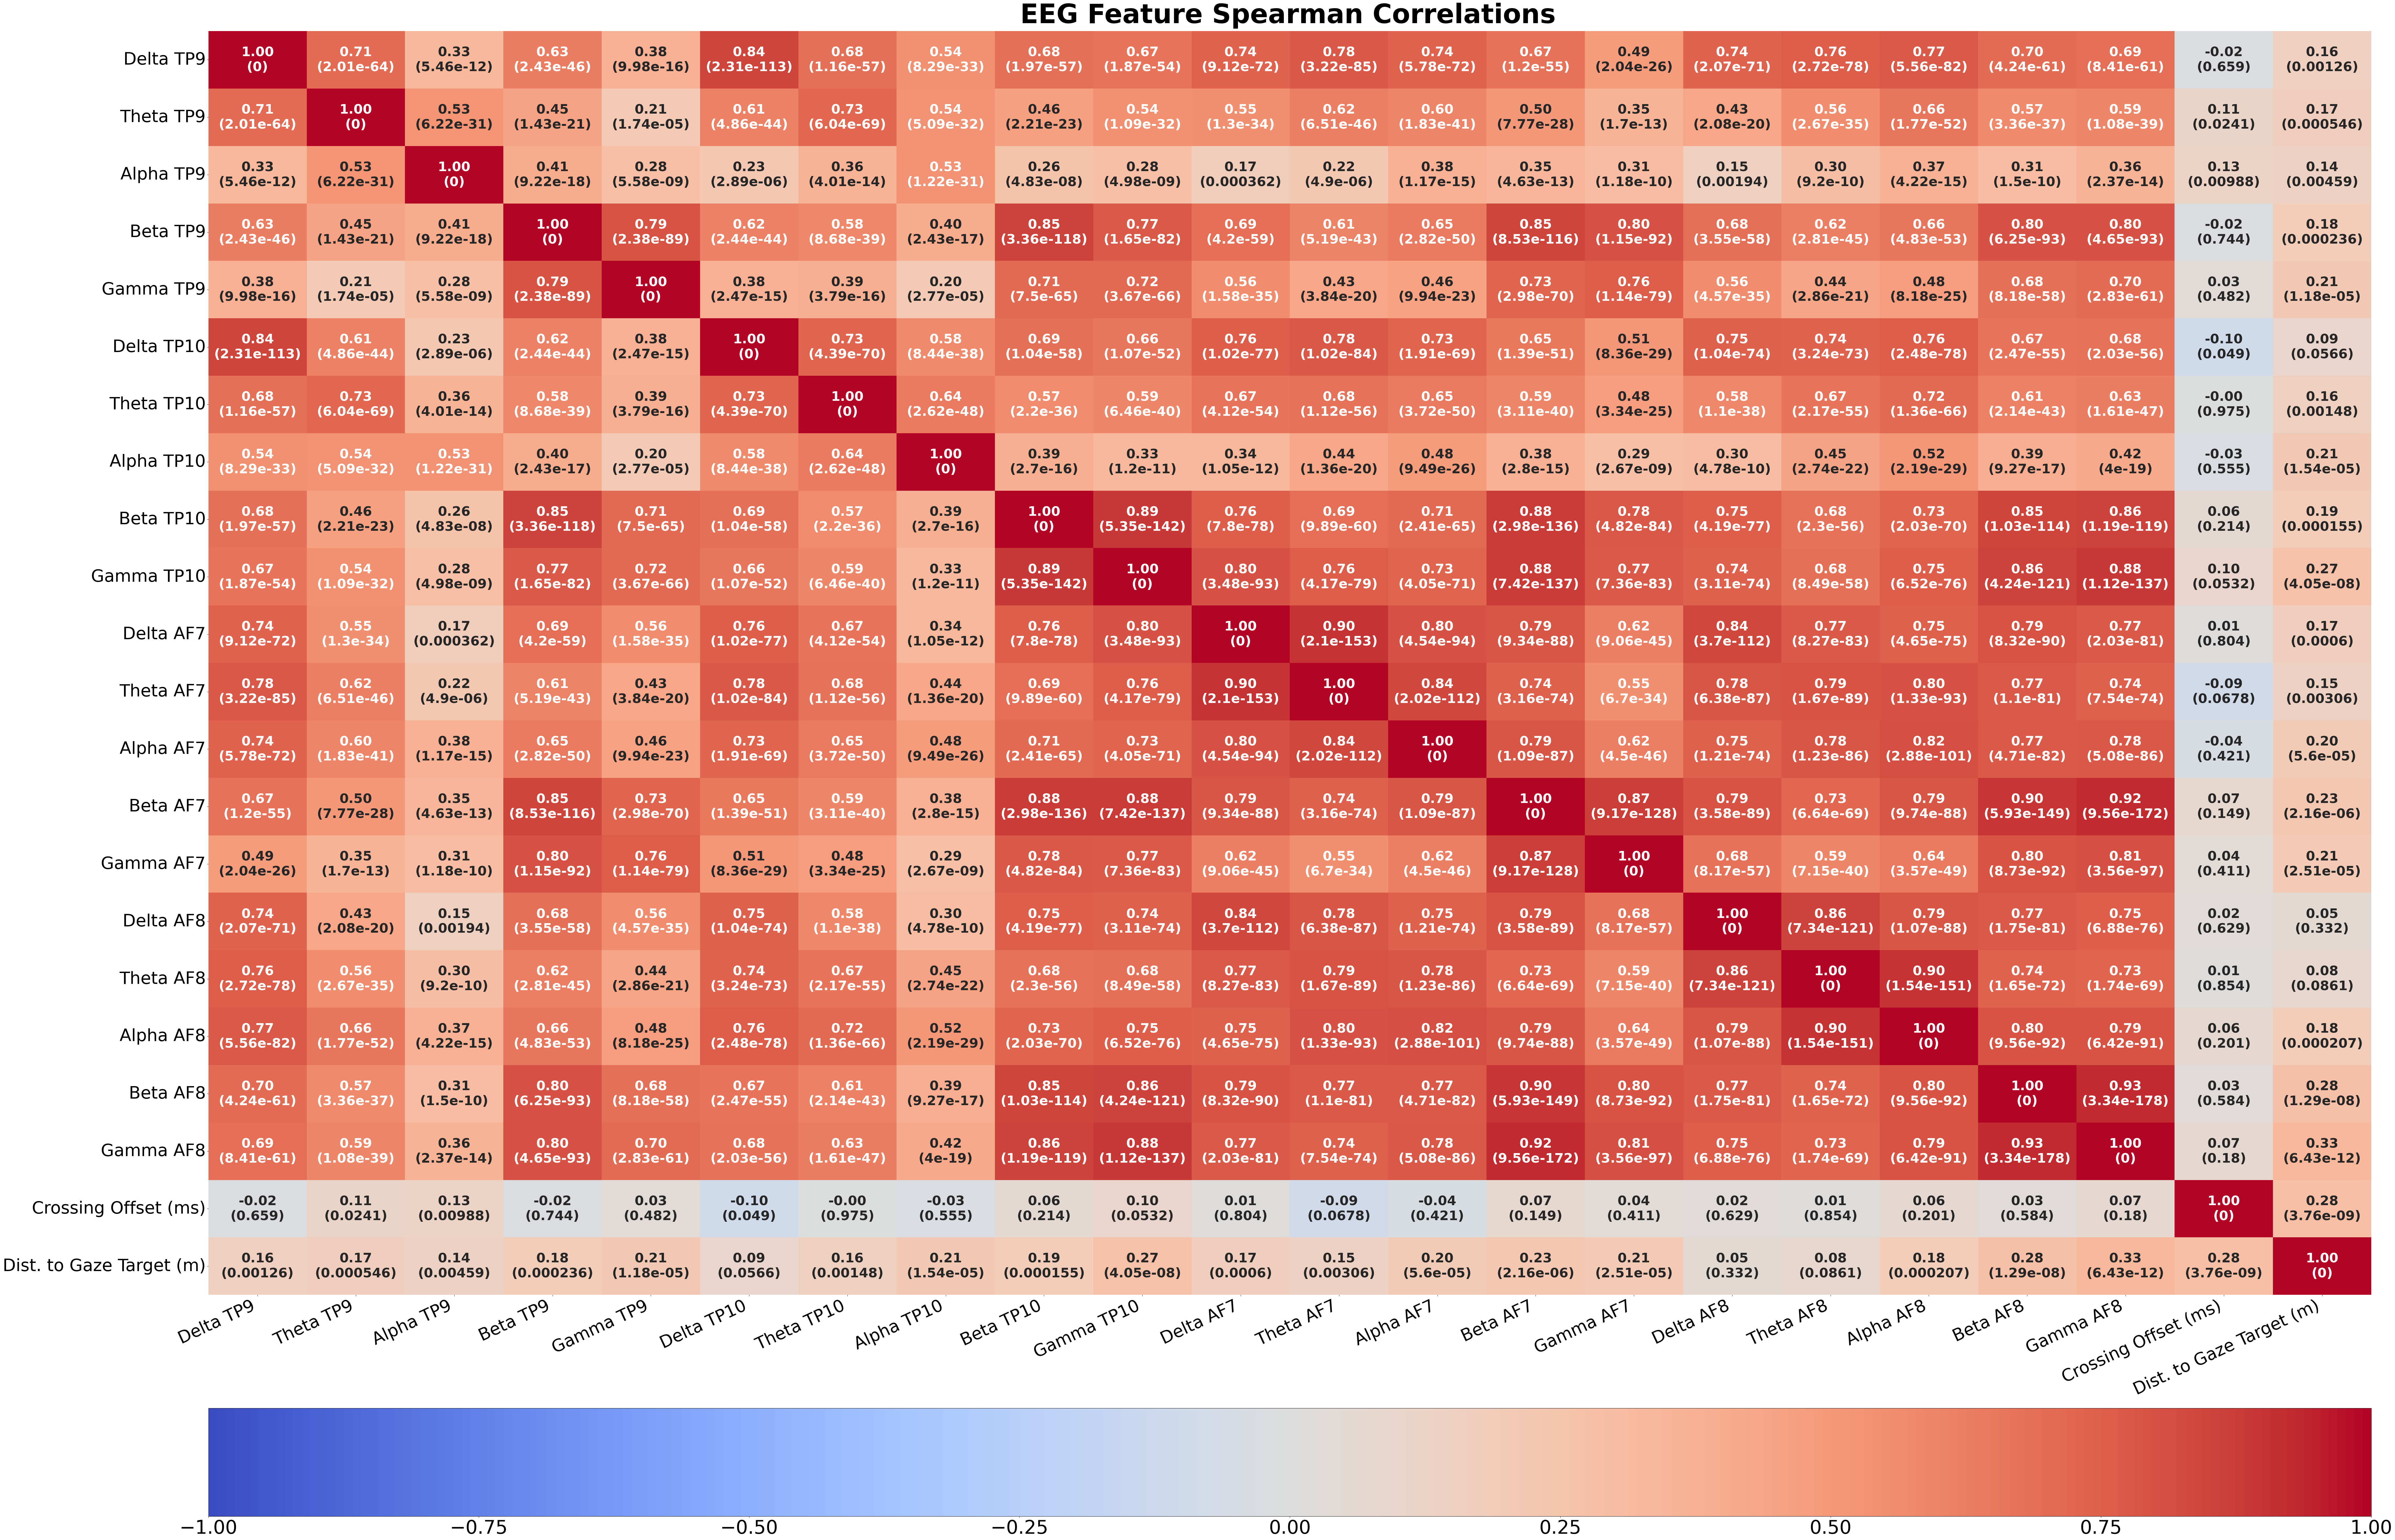

In [18]:
# encode raycast_target_category and raycast_target_type
#eeg_gaze_merged_df['raycast_target_category'], _ = pd.factorize(eeg_gaze_merged_df['raycast_target_category'])
#eeg_gaze_merged_df['raycast_target_type'], _ = pd.factorize(eeg_gaze_merged_df['raycast_target_type'])

# Determine columns. Also rearranges them
s_cols = [
    'Delta TP9', 'Theta TP9', 'Alpha TP9', 'Beta TP9', 'Gamma TP9',
    'Delta TP10','Theta TP10','Alpha TP10','Beta TP10','Gamma TP10',
    'Delta AF7', 'Theta AF7', 'Alpha AF7', 'Beta AF7', 'Gamma AF7',
    'Delta AF8', 'Theta AF8', 'Alpha AF8', 'Beta AF8', 'Gamma AF8',
    'Crossing Offset (ms)', 'Dist. to Gaze Target (m)']

s_df = eeg_gaze_merged_df[s_cols]

# Spearman correlation
s,p = MultipleCorrelations(s_df, method='spearman', display_df=False)

s_sub = s.loc[s_cols, s_cols]
p_sub = p.loc[s_cols, s_cols]

# Create labels
annot = s_sub.copy()
for i in range(s_sub.shape[0]):
    for j in range(s_sub.shape[1]):
        annot.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
    
# Plot correlationtable
fig, ax = plt.subplots(figsize=(80,60))
sns.heatmap(s_sub, 
    ax=ax,
    xticklabels=s_cols, 
    yticklabels=s_cols, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=annot,
    fmt='',
    annot_kws={'fontsize':35,'fontweight':'bold'},
    cbar=False
)
plt.tight_layout()
fig.suptitle('EEG Feature Spearman Correlations', fontsize='70', fontweight='bold', y=1.015)
plt.xticks(fontsize=45, rotation=25, ha="right")
plt.yticks(fontsize=45, rotation=0)

cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.07)
cbar.ax.tick_params(labelsize=50)

plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman.pdf'), format='pdf', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman.svg'), format='svg', bbox_inches='tight')

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/92099865.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02
(0.659)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/92099865.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11
(0.0241)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/92099865.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13
(0.

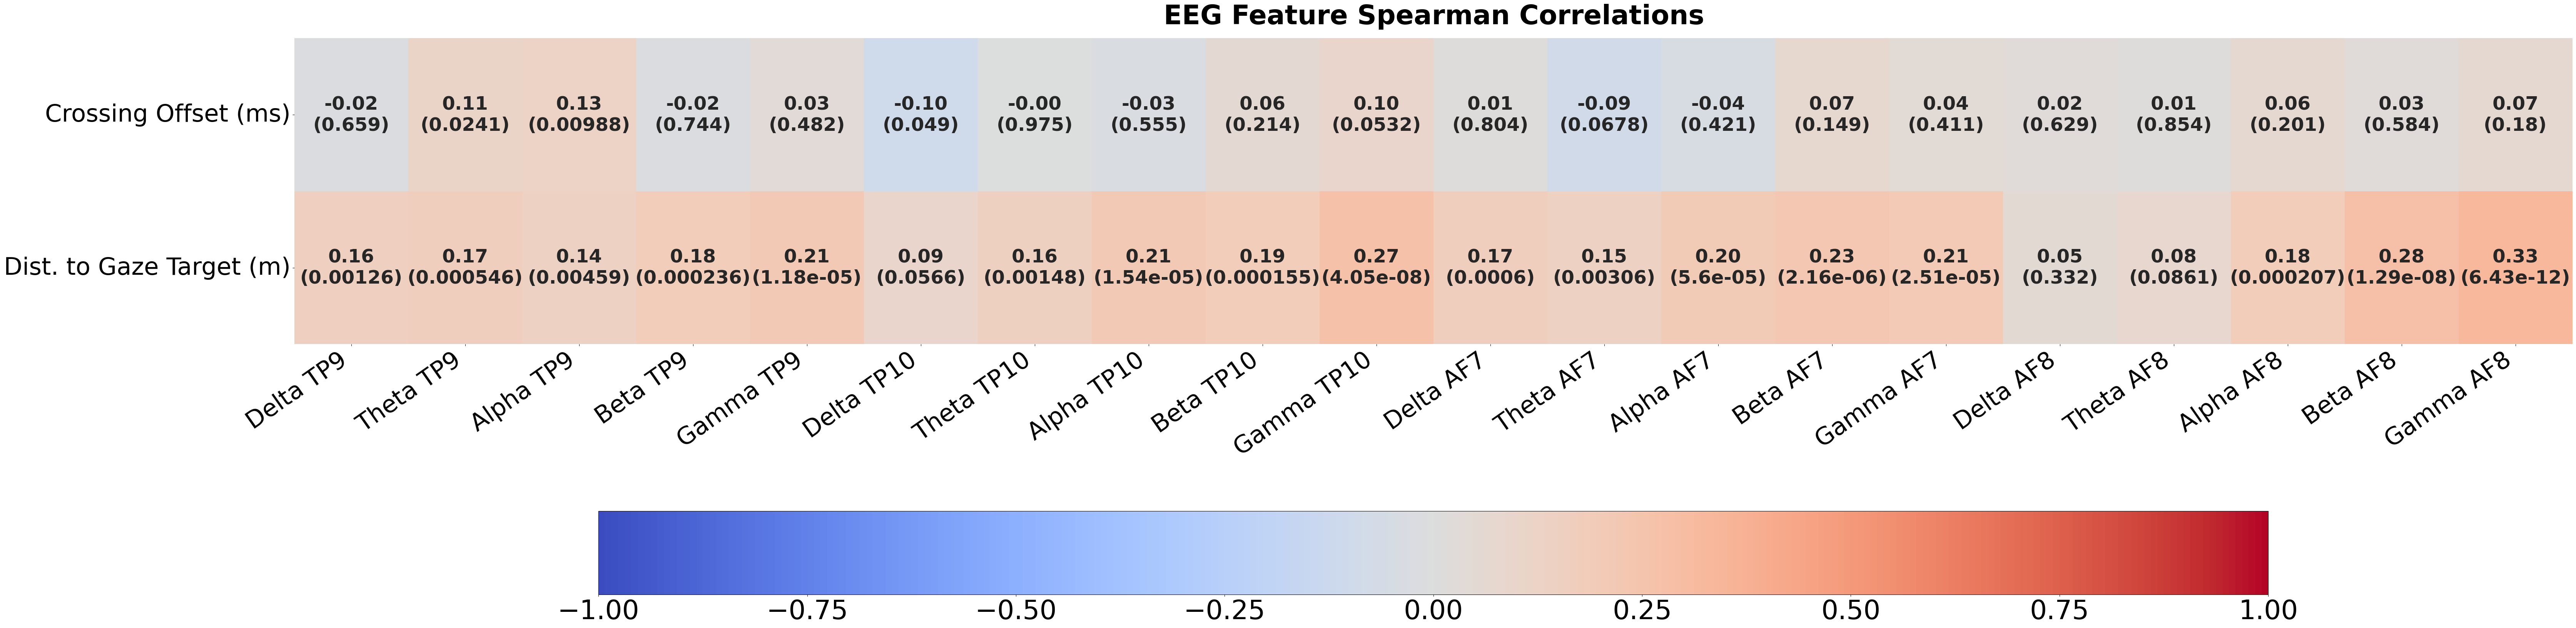

In [19]:
# Define subsets
x_cols = [
    'Delta TP9', 'Theta TP9', 'Alpha TP9', 'Beta TP9', 'Gamma TP9',
    'Delta TP10','Theta TP10','Alpha TP10','Beta TP10','Gamma TP10',
    'Delta AF7', 'Theta AF7', 'Alpha AF7', 'Beta AF7', 'Gamma AF7',
    'Delta AF8', 'Theta AF8', 'Alpha AF8', 'Beta AF8', 'Gamma AF8']
y_cols = [
    'Crossing Offset (ms)', 'Dist. to Gaze Target (m)']

# Subset the correlation matrix. rows = y, columns = x
s_sub = s.loc[y_cols, x_cols]
p_sub = p.loc[y_cols, x_cols]
annot_sub = s_sub.copy()
for i in range(s_sub.shape[0]):
    for j in range(s_sub.shape[1]):
        annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"

# Plot correlationtable
fig, ax = plt.subplots(figsize=(60,15))
sns.heatmap(s_sub, 
    ax=ax,
    xticklabels=s_sub.columns.values, 
    yticklabels=s_sub.index.values, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=annot_sub,
    fmt='',
    annot_kws={'fontsize':35,'fontweight':'bold'},
    cbar=False
)
plt.tight_layout()
fig.suptitle('EEG Feature Spearman Correlations', fontsize='50', fontweight='bold', y=1.05)
plt.xticks(fontsize=45, rotation=35, ha="right")
plt.yticks(fontsize=45, rotation=0)

cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.3)
cbar.ax.tick_params(labelsize=50)

plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_hor.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_hor.pdf'), format='pdf', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_hor.svg'), format='svg', bbox_inches='tight')

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/3749355645.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02
(0.659)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_27377/3749355645.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16
(0.00126)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"


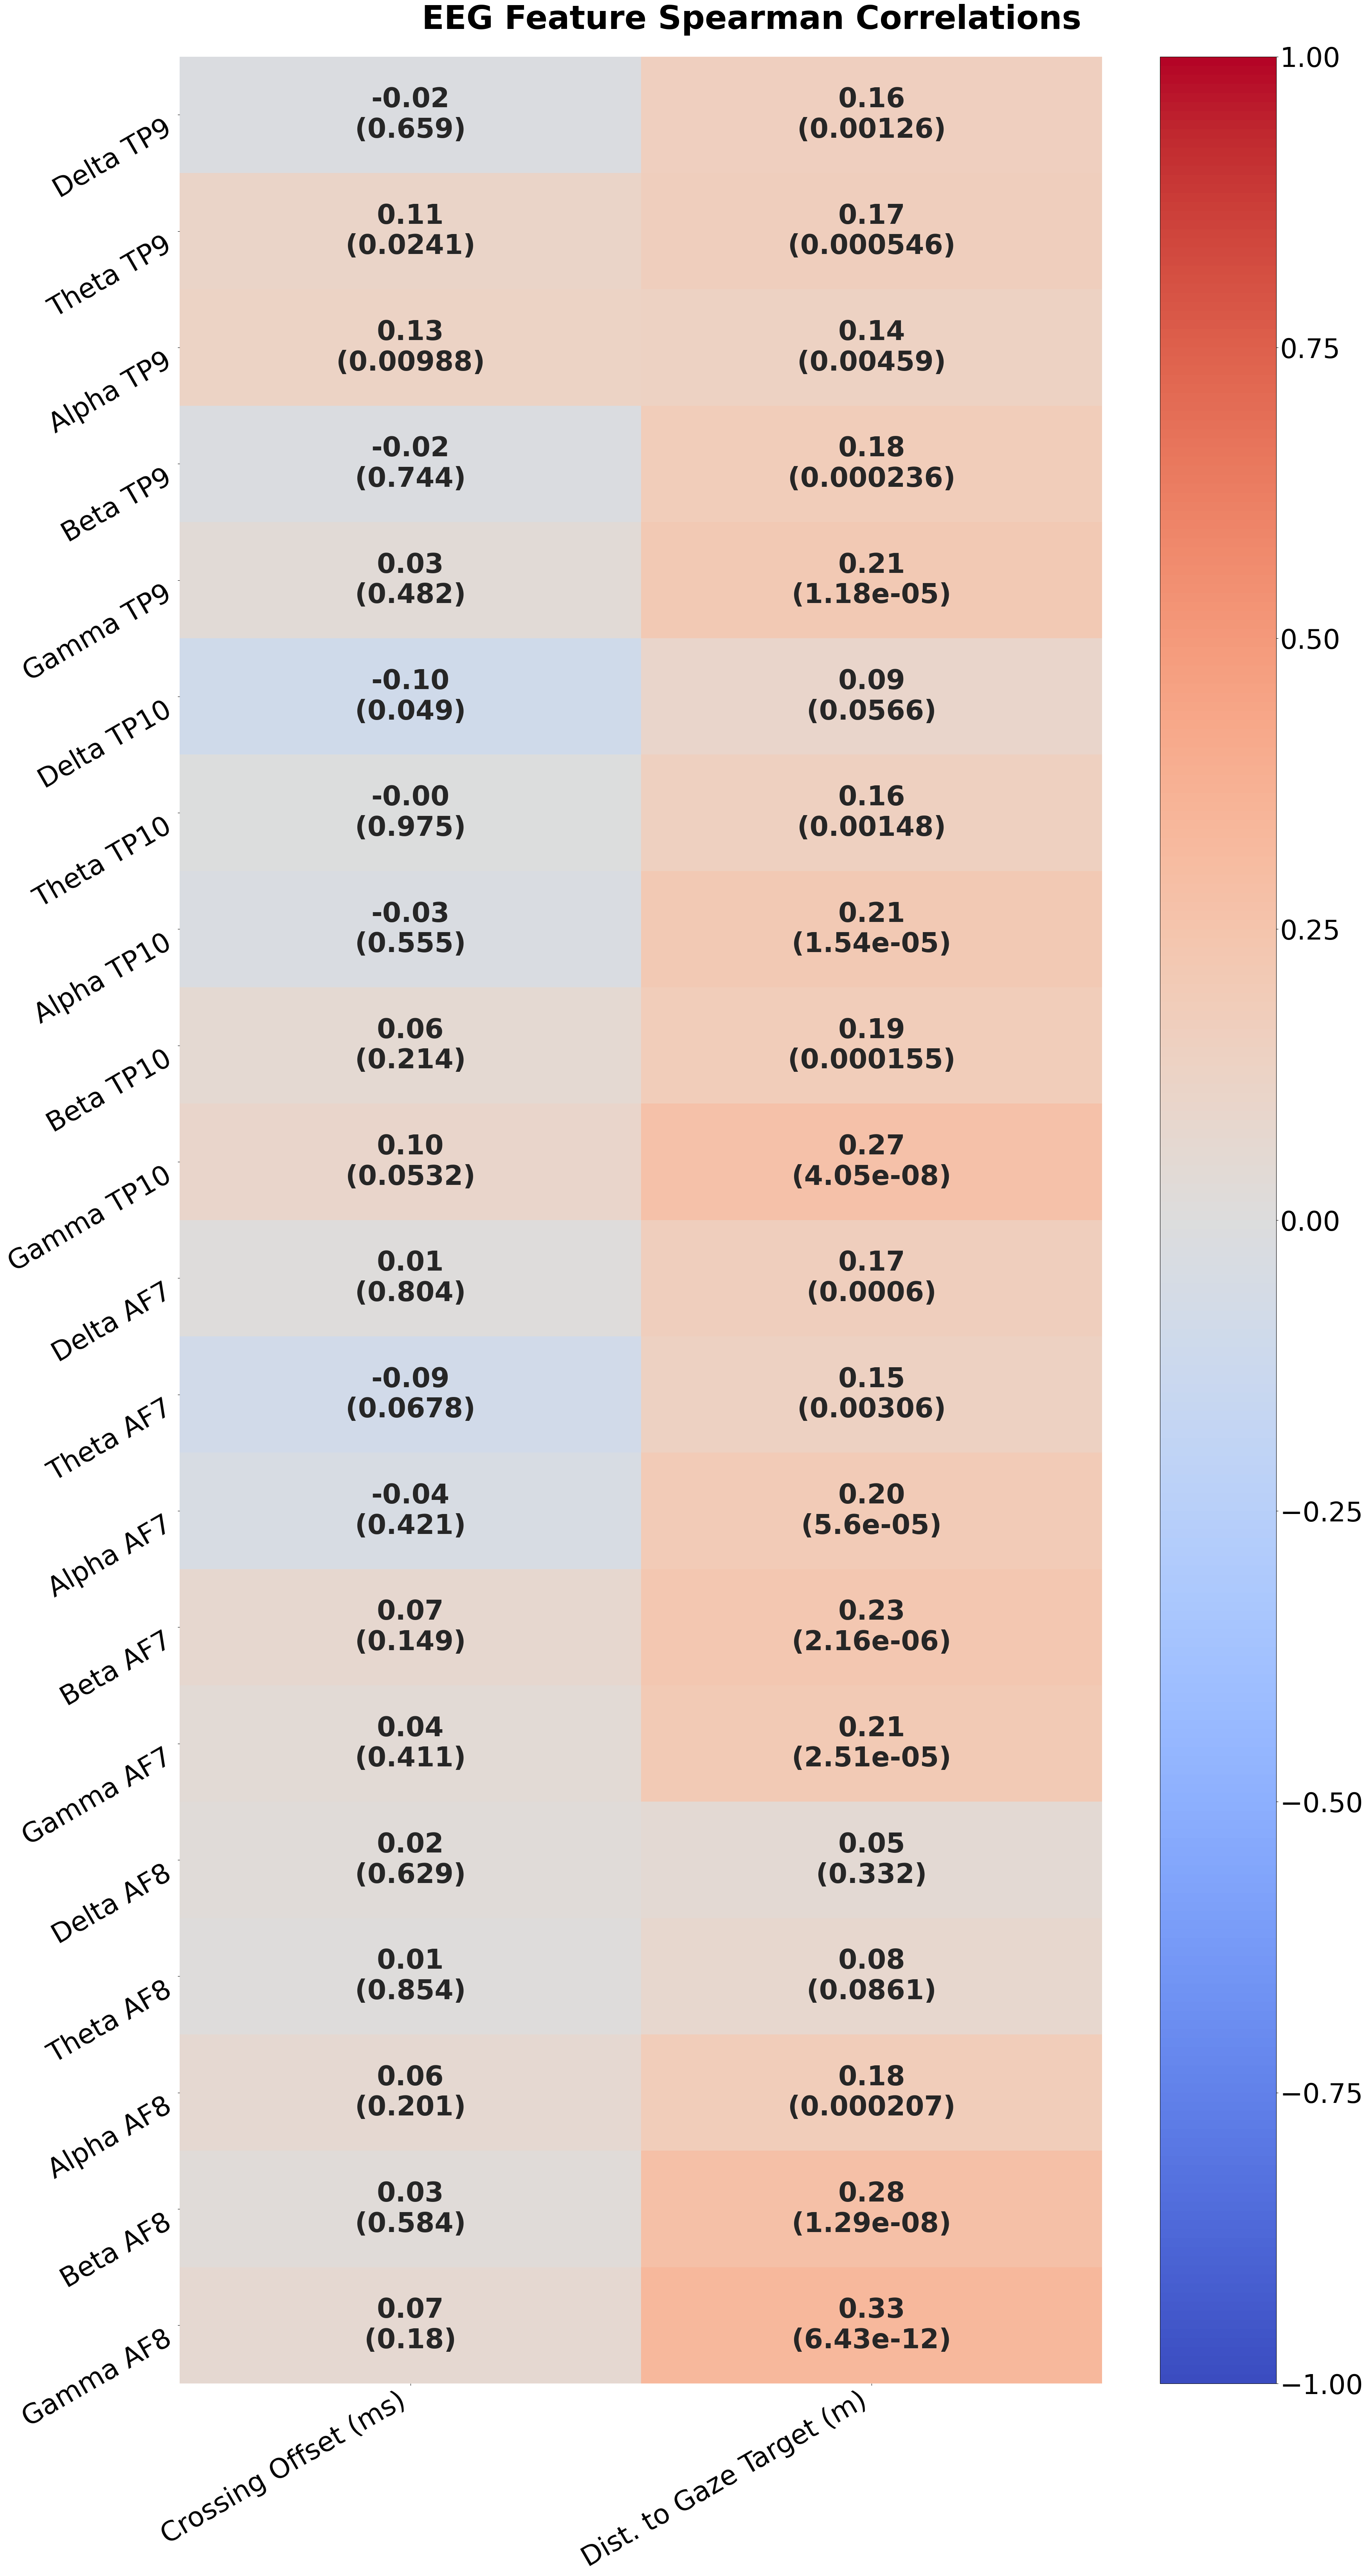

In [20]:
# Define subsets
y_cols = [
    'Delta TP9', 'Theta TP9', 'Alpha TP9', 'Beta TP9', 'Gamma TP9',
    'Delta TP10','Theta TP10','Alpha TP10','Beta TP10','Gamma TP10',
    'Delta AF7', 'Theta AF7', 'Alpha AF7', 'Beta AF7', 'Gamma AF7',
    'Delta AF8', 'Theta AF8', 'Alpha AF8', 'Beta AF8', 'Gamma AF8']
x_cols = [
    'Crossing Offset (ms)', 'Dist. to Gaze Target (m)']

# Subset the correlation matrix. rows = y, columns = x
s_sub = s.loc[y_cols, x_cols]
p_sub = p.loc[y_cols, x_cols]
annot_sub = s_sub.copy()
for i in range(s_sub.shape[0]):
    for j in range(s_sub.shape[1]):
        annot_sub.iloc[i, j] = f"{s_sub.iloc[i, j]:.2f}\n({p_sub.iloc[i, j]:.3g})"

# Plot correlationtable
fig, ax = plt.subplots(figsize=(30,60))
sns.heatmap(s_sub, 
    ax=ax,
    xticklabels=s_sub.columns.values, 
    yticklabels=s_sub.index.values, 
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=annot_sub,
    fmt='',
    annot_kws={'fontsize':50,'fontweight':'bold'},
    cbar=False
)
plt.tight_layout()
fig.suptitle('EEG Feature Spearman Correlations', fontsize='60', fontweight='bold', y=1.02)
plt.xticks(fontsize=50, rotation=30, ha='right')
plt.yticks(fontsize=50, rotation=30, va='top')

cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.05)
cbar.ax.tick_params(labelsize=50)

plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_vert.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_vert.pdf'), format='pdf', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DATA_DIR, 'eeg_spearman_vert.svg'), format='svg', bbox_inches='tight')

### Categorical Comparisons - ANOVA

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
# Anova columns
anova_cols = [
    'Delta TP9', 'Theta TP9', 'Alpha TP9', 'Beta TP9', 'Gamma TP9',
    'Delta TP10','Theta TP10','Alpha TP10','Beta TP10','Gamma TP10',
    'Delta AF7', 'Theta AF7', 'Alpha AF7', 'Beta AF7', 'Gamma AF7',
    'Delta AF8', 'Theta AF8', 'Alpha AF8', 'Beta AF8', 'Gamma AF8',
    'Participant ID','Gaze Target Category', 'Gaze Target Name']
anova_df = eeg_gaze_merged_df[anova_cols]

# Anova renaming
anova_df = anova_df.rename(columns={
        'Delta TP9':'Delta_TP9', 
        'Theta TP9':'Theta_TP9', 
        'Alpha TP9':'Alpha_TP9', 
        'Beta TP9':'Beta_TP9', 
        'Gamma TP9':'Gamma_TP9',
        'Delta TP10':'Delta_TP10', 
        'Theta TP10':'Theta_TP10', 
        'Alpha TP10':'Alpha_TP10', 
        'Beta TP10':'Beta_TP10', 
        'Gamma TP10':'Gamma_TP10',
        'Delta AF7':'Delta_AF7', 
        'Theta AF7':'Theta_AF7', 
        'Alpha AF7':'Alpha_AF7', 
        'Beta AF7':'Beta_AF7', 
        'Gamma AF7':'Gamma_AF7',
        'Delta AF8':'Delta_AF8', 
        'Theta AF8':'Theta_AF8', 
        'Alpha AF8':'Alpha_AF8', 
        'Beta AF8':'Beta_AF8', 
        'Gamma AF8':'Gamma_AF8',
        'Gaze Target Category':'Gaze_Target_Category',
        'Gaze Target Name':'Gaze_Target_Name',
        'Participant ID':'Participant_ID'})
anova_df = anova_df[anova_df['Gaze_Target_Category'].map(len) > 0]
display(anova_df.groupby(['Participant_ID', 'Gaze_Target_Category', 'Gaze_Target_Name']).size())
display(anova_df)

Participant_ID  Gaze_Target_Category  Gaze_Target_Name
P0              Agent                 Female               3
                                      Male                 1
                Environment           Buildings            1
                Vehicle               Body                 3
                                      Door                12
                                      Driver               1
                                      Wheel                2
P1              Agent                 Female               1
                Environment           Sidewalk             1
                                      Signal               1
                                      Tree                 5
                Vehicle               Body                12
                                      Door                21
                                      Driver              14
                                      Wheel                3
P2              Environment   

Delta_TP9  Theta_TP9  Alpha_TP9  Beta_TP9  Gamma_TP9  Delta_TP10  \
0     0.602711   1.584436   0.204817  1.223053   3.412172    0.892181   
1     0.061775   0.111005   0.076329  2.549013   7.319969    0.295013   
2     0.065984   0.126204   0.063880  2.076614   7.378804    0.191799   
3     0.067221   0.108347   0.084380  1.610157   6.485530    0.153020   
4     0.086192   0.122230   0.169840  1.461622   5.688120    0.088403   
..         ...        ...        ...       ...        ...         ...   
408   0.454031   0.449615  -0.047655  1.619383   3.915294    0.650342   
409   0.549090   0.516403  -0.059638  1.796212   3.857210    0.700924   
410   0.067526   0.142824  -0.023115  1.244309   2.937889    0.080260   
411   0.061326   0.183008  -0.000110  1.298452   2.303170    0.069349   
412   0.080847   0.230619   0.026723  1.358179   2.156937    0.090111   

     Theta_TP10  Alpha_TP10  Beta_TP10  Gamma_TP10  ...   Beta_AF7  Gamma_AF7  \
0      0.611420    0.245165   2.278923   20.200405  ...   4.959159   8.049836   
1      0.190695    0.133919   1.997126    4.133780  ...  12.242030  29.471463   
2      0.167595    0.138328   1.521299    4.304881  ...  13.797701  30.242650   
3      0.145896    0.143651   1.207761    4.403575  ...  12.926314  26.215038   
4      0.234320    0.142001   0.367031    4.102858  ...   9.991341  21.771447   
..          ...         ...        ...         ...  ...        ...        ...   
408    0.629973    0.011307   1.139161    2.214161  ...   6.377936   4.736315   
409    0.633838    0.002939   1.165671    2.071276  ...   6.984563   4.601178   
410    0.107782   -0.133962   1.121224    6.081454  ...   3.190221   1.488003   
411    0.102238   -0.106752   1.121843    5.064365  ...   2.677705   1.610461   
412    0.143142   -0.057867   1.116606    4.651254  ...   2.473378   1.783064   

     Delta_AF8  Theta_AF8  Alpha_AF8   Beta_AF8  Gamma_AF8  Participant_ID  \
0     1.928161   4.324820   1.243803   0.898815   0.899327              P0   
1     3.469231   1.181080   2.108630   3.079355   3.248957              P0   
2     2.328232   0.828664   2.108630   2.994343   4.392912              P0   
3     1.988483   1.025357   2.150905   2.575486   5.505853              P0   
4     0.642658   1.090611   1.867448   1.756288   6.658945              P0   
..         ...        ...        ...        ...        ...             ...   
408   0.398430   0.455021   0.536130   8.636836   1.972325              P6   
409   0.402641   0.419536   0.498063   9.058439   2.125509              P6   
410   0.238335   0.523621   0.198930   9.876969   2.445789              P6   
411   0.262230   0.667512   0.205011  10.558591   3.037579              P6   
412   0.547836   0.893227   0.322948  10.786170   2.987934              P6   

     Gaze_Target_Category  Gaze_Target_Name  
0             Environment         Buildings  
1                 Vehicle              Body  
2                 Vehicle             Wheel  
3                 Vehicle             Wheel  
4                 Vehicle              Door  
..                    ...               ...  
408               Vehicle              Door  
409               Vehicle              Door  
410               Vehicle             Wheel  
411               Vehicle             Wheel  
412               Vehicle             Wheel  

[413 rows x 23 columns]

In [23]:
model = smf.ols('Alpha_AF8 ~ C(Gaze_Target_Category)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("""\nPR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)""")

                             sum_sq     df         F    PR(>F)
C(Gaze_Target_Category)   16.511086    2.0  4.912494  0.007793
Residual                 689.013051  410.0       NaN       NaN

PR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)


In [24]:
model = smf.ols('Alpha_AF8 ~ C(Gaze_Target_Name)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("""\nPR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)""")

                         sum_sq     df         F    PR(>F)
C(Gaze_Target_Name)   27.935103   10.0  1.657334  0.088702
Residual             677.589034  402.0       NaN       NaN

PR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)


In [25]:
model = smf.ols('Alpha_AF8 ~ C(Gaze_Target_Category) + C(Gaze_Target_Name)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("""\nPR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)""")

                             sum_sq     df         F    PR(>F)
C(Gaze_Target_Category)   18.572707    2.0  5.509408  0.004360
C(Gaze_Target_Name)       29.500641   10.0  1.750214  0.067957
Residual                 677.589034  402.0       NaN       NaN

PR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)


In [26]:
model = smf.ols('Alpha_AF8 ~ C(Gaze_Target_Category) + C(Gaze_Target_Name) + C(Gaze_Target_Category):C(Gaze_Target_Name)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("""\nPR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)""")

                                                   sum_sq     df  \
C(Gaze_Target_Category)                               NaN    2.0   
C(Gaze_Target_Name)                          1.397664e-12   10.0   
C(Gaze_Target_Category):C(Gaze_Target_Name)  3.422747e+01   20.0   
Residual                                     6.798697e+02  402.0   

                                                        F    PR(>F)  
C(Gaze_Target_Category)                               NaN       NaN  
C(Gaze_Target_Name)                          8.264247e-14  1.000000  
C(Gaze_Target_Category):C(Gaze_Target_Name)  1.011918e+00  0.315049  
Residual                                              NaN       NaN  

PR(>F) = p-value
    If < 0.05, the differences in means across categories are statistically significant
F = F-statistic (how strong the between-group difference is)


/Users/ryankim/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/ryankim/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/ryankim/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/ryankim/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [47]:
anova_eeg_cols = [
    'Delta_TP9', 'Theta_TP9', 'Alpha_TP9', 'Beta_TP9', 'Gamma_TP9',
    'Delta_TP10','Theta_TP10','Alpha_TP10','Beta_TP10','Gamma_TP10',
    'Delta_AF7', 'Theta_AF7', 'Alpha_AF7', 'Beta_AF7', 'Gamma_AF7',
    'Delta_AF8', 'Theta_AF8', 'Alpha_AF8', 'Beta_AF8', 'Gamma_AF8']
anova_cat1 = 'Participant_ID'
anova_cat2 = 'Gaze_Target_Name'

anova_results = []
for col in anova_eeg_cols:
    #formula = f'{col} ~ C({anova_cat1}) + C({anova_cat2}) + C({anova_cat1}):C({anova_cat2})'
    formula = f'{col} ~ C({anova_cat2})'
    model = smf.ols(formula, data=anova_df).fit()
    anova = sm.stats.anova_lm(model, typ=2)

    # Extract rows from ANOVA table
    #for factor in [f'C({anova_cat1})', f'C({anova_cat2})', f'C({anova_cat1}):C({anova_cat2})']:
    factor = f'C({anova_cat2})'
    row = anova.loc[factor]
    anova_results.append({
                'EEG_Measure': col,
                'Factor': factor,
                'SumSq': row['sum_sq'],
                'DF': row['df'],
                'F': row['F'],
                'p_value': row['PR(>F)']})
anova_results_df = pd.DataFrame(anova_results)
anova_results_df

EEG_Measure               Factor        SumSq    DF         F       p_value
0    Delta_TP9  C(Gaze_Target_Name)     5.970279  10.0  1.712664  7.575293e-02
1    Theta_TP9  C(Gaze_Target_Name)    24.288485  10.0  2.099649  2.352497e-02
2    Alpha_TP9  C(Gaze_Target_Name)     4.895226  10.0  2.145738  2.033336e-02
3     Beta_TP9  C(Gaze_Target_Name)   684.853305  10.0  4.219179  1.374041e-05
4    Gamma_TP9  C(Gaze_Target_Name)  1634.839044  10.0  3.540883  1.662344e-04
5   Delta_TP10  C(Gaze_Target_Name)     5.983478  10.0  2.953242  1.352813e-03
6   Theta_TP10  C(Gaze_Target_Name)    13.857899  10.0  1.751103  6.778192e-02
7   Alpha_TP10  C(Gaze_Target_Name)    16.822516  10.0  1.597740  1.048104e-01
8    Beta_TP10  C(Gaze_Target_Name)   254.271341  10.0  4.307299  9.900139e-06
9   Gamma_TP10  C(Gaze_Target_Name)  1698.357545  10.0  6.712592  1.121128e-09
10   Delta_AF7  C(Gaze_Target_Name)    45.529510  10.0  9.536052  2.756127e-14
11   Theta_AF7  C(Gaze_Target_Name)    58.320021  10.0  3.051174  9.591662e-04
12   Alpha_AF7  C(Gaze_Target_Name)    28.662508  10.0  2.627663  4.158111e-03
13    Beta_AF7  C(Gaze_Target_Name)  3197.971028  10.0  5.160169  4.029633e-07
14   Gamma_AF7  C(Gaze_Target_Name)  3852.891574  10.0  3.459599  2.231036e-04
15   Delta_AF8  C(Gaze_Target_Name)    77.161650  10.0  1.860655  4.905455e-02
16   Theta_AF8  C(Gaze_Target_Name)   160.228241  10.0  3.086861  8.456764e-04
17   Alpha_AF8  C(Gaze_Target_Name)    27.935103  10.0  1.657334  8.870226e-02
18    Beta_AF8  C(Gaze_Target_Name)  2495.495125  10.0  3.441428  2.382337e-04
19   Gamma_AF8  C(Gaze_Target_Name)  4393.206499  10.0  3.249962  4.737732e-04

In [48]:
print('# Samples:', len(anova_df))  # How many rows?

ss_total = sum(anova_results_df['SumSq'])
anova_results_df['EtaSq'] = anova_results_df['SumSq'] / ss_total
display(anova_results_df)

# Samples: 413


EEG_Measure               Factor        SumSq    DF         F  \
0    Delta_TP9  C(Gaze_Target_Name)     5.970279  10.0  1.712664   
1    Theta_TP9  C(Gaze_Target_Name)    24.288485  10.0  2.099649   
2    Alpha_TP9  C(Gaze_Target_Name)     4.895226  10.0  2.145738   
3     Beta_TP9  C(Gaze_Target_Name)   684.853305  10.0  4.219179   
4    Gamma_TP9  C(Gaze_Target_Name)  1634.839044  10.0  3.540883   
5   Delta_TP10  C(Gaze_Target_Name)     5.983478  10.0  2.953242   
6   Theta_TP10  C(Gaze_Target_Name)    13.857899  10.0  1.751103   
7   Alpha_TP10  C(Gaze_Target_Name)    16.822516  10.0  1.597740   
8    Beta_TP10  C(Gaze_Target_Name)   254.271341  10.0  4.307299   
9   Gamma_TP10  C(Gaze_Target_Name)  1698.357545  10.0  6.712592   
10   Delta_AF7  C(Gaze_Target_Name)    45.529510  10.0  9.536052   
11   Theta_AF7  C(Gaze_Target_Name)    58.320021  10.0  3.051174   
12   Alpha_AF7  C(Gaze_Target_Name)    28.662508  10.0  2.627663   
13    Beta_AF7  C(Gaze_Target_Name)  3197.971028  10.0  5.160169   
14   Gamma_AF7  C(Gaze_Target_Name)  3852.891574  10.0  3.459599   
15   Delta_AF8  C(Gaze_Target_Name)    77.161650  10.0  1.860655   
16   Theta_AF8  C(Gaze_Target_Name)   160.228241  10.0  3.086861   
17   Alpha_AF8  C(Gaze_Target_Name)    27.935103  10.0  1.657334   
18    Beta_AF8  C(Gaze_Target_Name)  2495.495125  10.0  3.441428   
19   Gamma_AF8  C(Gaze_Target_Name)  4393.206499  10.0  3.249962   

         p_value     EtaSq  
0   7.575293e-02  0.000320  
1   2.352497e-02  0.001300  
2   2.033336e-02  0.000262  
3   1.374041e-05  0.036659  
4   1.662344e-04  0.087511  
5   1.352813e-03  0.000320  
6   6.778192e-02  0.000742  
7   1.048104e-01  0.000900  
8   9.900139e-06  0.013611  
9   1.121128e-09  0.090911  
10  2.756127e-14  0.002437  
11  9.591662e-04  0.003122  
12  4.158111e-03  0.001534  
13  4.029633e-07  0.171183  
14  2.231036e-04  0.206241  
15  4.905455e-02  0.004130  
16  8.456764e-04  0.008577  
17  8.870226e-02  0.001495  
18  2.382337e-04  0.133581  
19  4.737732e-04  0.235163

In [50]:
anova_results_df.to_csv(os.path.join(_OUTPUT_DATA_DIR, '1WayAnova.csv'))